# Air Quality in India

**Project Goal**

The primary goal is to identify and characterize distinct types of air pollution across monitoring stations in India (2015-2020) by grouping them based on their structural pollution profiles. This moves beyond simple $\text{AQI}$ forecasting to provide actionable insights into the root causes of air pollution, thereby enabling the development of targeted, location-specific policies.
***

**Problem Statement**

Air quality management in India often relies on blanket policies that fail to account for the heterogeneity of pollution sources across different cities and stations. A city dominated by industrial emissions ($\text{SO}_2, \text{NO}_2$) requires a fundamentally different intervention than an area dominated by traffic and construction dust ($\text{PM}_{2.5}, \text{PM}_{10}$). We aim to solve this by classifying areas based on the composition and temporal rhythm of their pollutants.
***

**Methodology: Causal Clustering Approach**

This project utilizes an unsupervised learning approach to segment stations into clusters, followed by a hybrid interpretation method for policy linkage.

***
**Expected Outcome**

The project will deliver a clear map of India showing the dominant type of pollution in each major metropolitan area. The primary output is the Policy Recommendation Matrix, which provides policymakers with the necessary information to allocate resources effectively and implement targeted, science-backed interventions to improve air quality.

#### Problem statements:
- Gain domain knowledge, which pollution or emission represents what. (Probably we can connect certain emissions with industry types e.g. Traffic / Industry pollution)
- Which emissions have a significant impact on the air quality? (explorative data analysis - show correlation and visualize)
- Explore pollution profiles by regions/cities, make conclusion about trends and types of pollution in certain cities. (building map might be usefull)
- How did the air quality change over time in both specific cities and general in India? (explorative data analysis - visualize)
- Does the air quality in any particular cities has a significant impact on the country's general air quality? (data pre-processing - identify outliers)

#### Project goals:
- Eximine the air quality in India from 2015 to 2020 based on the measurements done in different cities
- Based on the data from 2015 to 2020 make a prediction about the air quality in 2021 in the country overall and in the particular cities! (Machine learning model - make a                                                                                                                              prediction through multiple linear                                                                                                                     regression)
- Apply Causal Clustering (K-Means/DBSCAN) to segment stations and cities based on their structural emission profiles. Interpret and qualitatively label the clusters (e.g., 'Industrial-Thermal', 'Traffic-Dominant').
- Propose an Optimized Monitoring Network by using spatial analysis (e.g., Kriging) to identify high-uncertainty areas in need of new sensors, ensuring future data collection is maximized for effective decision-making. (I am not sure about this one)

#### Tasks:
- Add in project Domain knowledge and context
- Data cleaning and preparation  (Ekaterina)
- Explorative data analysis (Kristian)
- Machine learning model: regression (Nathan?)
- Machine learning model: clustering (all?)

In [31]:
!pip install -q --upgrade kagglehub
!pip install -q missingno
!pip install -q tabulate

In [32]:
# import libraries
import kagglehub
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tabulate
import os
import warnings
import plotly.express as px
import json
import scipy.stats as st
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import lightgbm as lgb
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import silhouette_score

## Data load and preprocessing

In [33]:
#loading data using kaggle api
path = kagglehub.dataset_download("rohanrao/air-quality-data-in-india")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ASUS\.cache\kagglehub\datasets\rohanrao\air-quality-data-in-india\versions\12


In [34]:
# Construct the full file path for one of the dataset files
station_hour = os.path.join(path, 'station_hour.csv') 
station_day = os.path.join(path, 'station_day.csv')
city_day = os.path.join(path, 'city_day.csv')
city_hour = os.path.join(path, 'city_hour.csv')
stations = os.path.join(path, 'stations.csv')


# Load the data into a DataFrame
station_hour = pd.read_csv(station_hour)
station_day = pd.read_csv(station_day)
city_day = pd.read_csv(city_day)
city_hour = pd.read_csv(city_hour)
stations = pd.read_csv(stations)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29148\4204765171.py:10: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  station_hour = pd.read_csv(station_hour)


In [35]:
# we are planning to work primarily with station hour, but i have uploaded all datasets
station_hour = pd.DataFrame(station_hour)
station_day = pd.DataFrame(station_day)
city_day = pd.DataFrame(city_day)
city_hour = pd.DataFrame(city_hour)
stations = pd.DataFrame(stations)

In [36]:
# overview that station_hour data loaded correctly
station_hour.head()

,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24 17:00:00,60.50,98.00,2.35,30.80,18.25,8.50,0.1,11.85,126.40,0.1,6.10,0.10,NaN,NaN
1,AP001,2017-11-24 18:00:00,65.50,111.25,2.70,24.20,15.07,9.77,0.1,13.17,117.12,0.1,6.25,0.15,NaN,NaN
2,AP001,2017-11-24 19:00:00,80.00,132.00,2.10,25.18,15.15,12.02,0.1,12.08,98.98,0.2,5.98,0.18,NaN,NaN
3,AP001,2017-11-24 20:00:00,81.50,133.25,1.95,16.25,10.23,11.58,0.1,10.47,112.20,0.2,6.72,0.10,NaN,NaN
4,AP001,2017-11-24 21:00:00,75.25,116.00,1.43,17.48,10.43,12.03,0.1,9.12,106.35,0.2,5.75,0.08,NaN,NaN


In [37]:
# cheking for datatypes
station_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2589083 entries, 0 to 2589082
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   StationId   object 
 1   Datetime    object 
 2   PM2.5       float64
 3   PM10        float64
 4   NO          float64
 5   NO2         float64
 6   NOx         float64
 7   NH3         float64
 8   CO          float64
 9   SO2         float64
 10  O3          float64
 11  Benzene     float64
 12  Toluene     float64
 13  Xylene      float64
 14  AQI         float64
 15  AQI_Bucket  object 
dtypes: float64(13), object(3)
memory usage: 316.1+ MB


In [38]:
# the datetime variable should be stored in the appropriate type
station_hour['Datetime'] = pd.to_datetime(station_hour['Datetime'])

In [39]:
#creating separate time variables
#variable with date
station_hour['Date'] = station_hour['Datetime'].dt.date

#variable with time
station_hour['Time'] = station_hour['Datetime'].dt.hour

#variable with month
station_hour['Month'] = station_hour['Datetime'].dt.month

#variable with day of the week (0-Monday, 6-Sunday)
station_hour['Weekday'] = station_hour['Datetime'].dt.weekday

#Defining period of the day (Night, Morning, Day, Evening)
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Day', 'Evening']
station_hour['Time_Period'] = pd.cut(station_hour['Time'], bins=bins, labels=labels, right=False, include_lowest=True)

In [40]:
# overviewing station_hour data after creating additional time variables
station_hour.head()

,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,Benzene,Toluene,Xylene,AQI,AQI_Bucket,Date,Time,Month,Weekday,Time_Period
0,AP001,2017-11-24 17:00:00,60.50,98.00,2.35,30.80,18.25,8.50,0.1,11.85,...,0.1,6.10,0.10,NaN,NaN,2017-11-24,17,11,4,Day
1,AP001,2017-11-24 18:00:00,65.50,111.25,2.70,24.20,15.07,9.77,0.1,13.17,...,0.1,6.25,0.15,NaN,NaN,2017-11-24,18,11,4,Evening
2,AP001,2017-11-24 19:00:00,80.00,132.00,2.10,25.18,15.15,12.02,0.1,12.08,...,0.2,5.98,0.18,NaN,NaN,2017-11-24,19,11,4,Evening
3,AP001,2017-11-24 20:00:00,81.50,133.25,1.95,16.25,10.23,11.58,0.1,10.47,...,0.2,6.72,0.10,NaN,NaN,2017-11-24,20,11,4,Evening
4,AP001,2017-11-24 21:00:00,75.25,116.00,1.43,17.48,10.43,12.03,0.1,9.12,...,0.2,5.75,0.08,NaN,NaN,2017-11-24,21,11,4,Evening


In [41]:
# overview that station_day data loaded correctly
station_day.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


In [42]:
# cheking for correct datatypes
station_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108035 entries, 0 to 108034
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   StationId   108035 non-null  object 
 1   Date        108035 non-null  object 
 2   PM2.5       86410 non-null   float64
 3   PM10        65329 non-null   float64
 4   NO          90929 non-null   float64
 5   NO2         91488 non-null   float64
 6   NOx         92535 non-null   float64
 7   NH3         59930 non-null   float64
 8   CO          95037 non-null   float64
 9   SO2         82831 non-null   float64
 10  O3          82467 non-null   float64
 11  Benzene     76580 non-null   float64
 12  Toluene     69333 non-null   float64
 13  Xylene      22898 non-null   float64
 14  AQI         87025 non-null   float64
 15  AQI_Bucket  87025 non-null   object 
dtypes: float64(13), object(3)
memory usage: 13.2+ MB


In [43]:
# the same as in the previous dataset date values should be stored as date
station_day['Date'] = pd.to_datetime(station_day['Date'])

In [44]:
# overview that city_day data loaded correctly
city_day.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [45]:
# cheking for correct datatypes
city_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


In [46]:
# the same as in the previous dataset date vales should be stored as date
city_day['Date'] = pd.to_datetime(city_day['Date'])

In [47]:
# overview that city_hour data loaded correctly
city_hour.head()

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01 01:00:00,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,NaN,0.0,0.0,0.0,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,NaN,0.0,0.0,0.0,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,NaN,NaN,0.08,19.32,11.08,NaN,0.08,52.83,NaN,0.0,0.0,0.0,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,NaN,NaN,0.30,16.45,9.20,NaN,0.30,39.53,153.58,0.0,0.0,0.0,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,NaN,NaN,0.12,14.90,7.85,NaN,0.12,32.63,NaN,0.0,0.0,0.0,NaN,NaN


In [48]:
# cheking for correct datatypes
city_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707875 entries, 0 to 707874
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   City        707875 non-null  object 
 1   Datetime    707875 non-null  object 
 2   PM2.5       562787 non-null  float64
 3   PM10        411138 non-null  float64
 4   NO          591243 non-null  float64
 5   NO2         590753 non-null  float64
 6   NOx         584651 non-null  float64
 7   NH3         435333 non-null  float64
 8   CO          621358 non-null  float64
 9   SO2         577502 non-null  float64
 10  O3          578667 non-null  float64
 11  Benzene     544229 non-null  float64
 12  Toluene     487268 non-null  float64
 13  Xylene      252046 non-null  float64
 14  AQI         578795 non-null  float64
 15  AQI_Bucket  578795 non-null  object 
dtypes: float64(13), object(3)
memory usage: 86.4+ MB


In [49]:
# the same as in the previous dataset date vales should be stored as date
city_hour['Datetime'] = pd.to_datetime(city_hour['Datetime'])

In [50]:
# creating additional time variables for the city_hour dataset
city_hour['Date'] = city_hour['Datetime'].dt.date
city_hour['Time'] = city_hour['Datetime'].dt.hour

In [51]:
# function for calculating share of missing values for each variable in the datasets
def get_missing_percentage_for_plot(df, df_name):
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_df = mis_val_percent.reset_index()
    mis_val_df.columns = ['Feature', 'Missing_Percentage']
    mis_val_df['Dataset'] = df_name
    mis_val_df = mis_val_df[mis_val_df['Missing_Percentage'] > 0]
    return mis_val_df

In [52]:
datasets_to_process = [
    (city_day, 'city_day'),
    (city_hour, 'city_hour'),
    (station_day, 'station_day'),
    (station_hour, 'station_hour')
]
all_missing_data = pd.concat([
    get_missing_percentage_for_plot(df, name) for df, name in datasets_to_process
], ignore_index=True)

In [53]:
# preparing data for heatmap visualization
heatmap_data = all_missing_data.pivot_table(
    index='Feature',
    columns='Dataset',
    values='Missing_Percentage'
).fillna(0.0).round(1)

In [54]:
# sorting values for visual representation
heatmap_data['Total_Missing_Avg'] = heatmap_data.sum(axis=1) / len(datasets_to_process)
heatmap_data = heatmap_data.sort_values(by='Total_Missing_Avg', ascending=False).drop(columns=['Total_Missing_Avg'])

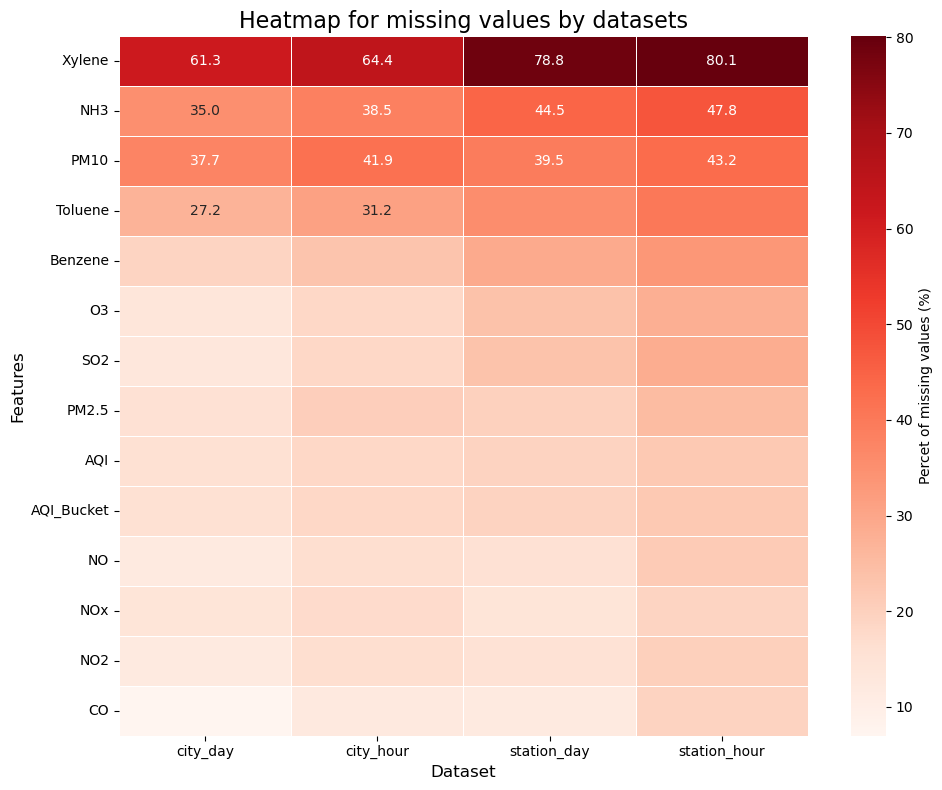

In [55]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    heatmap_data,
    annot=True,             
    fmt=".1f",             
    cmap="Reds",
    linewidths=.5,          
    cbar_kws={'label': 'Percet of missing values (%)'} # Подпись цветовой шкалы
)

plt.title('Heatmap for missing values by datasets', fontsize=16)
plt.ylabel('Features', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('missing_values_heatmap_comparison.png')
plt.show()

***
**What data we choose and why**
- Hourly data hasthe greateste percetage of missing values for each variable
- In general the missing values for data by stations is greater
**Despite the fact that `station_hour` dataset contains the greatest number of missing values, but meanwhile the greatest number of observatios, for our project thdetailedile data suits the aimour project the best.**

We choose:
- **station-level** data for geaographical reasons, as its depicts local picture of pollution
- **hour-level** data since it is importamodellingmelling purpouses, and allows more flexible aggregation, but we should pay attention to fact that hourly data is sesetive to noise
***

### Imputing missing values

In this subsectio of data preparation we firstly analyse missing values patterns, then choose the strategy for filling in missing values.

In [56]:
station_hour.head()

,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,Benzene,Toluene,Xylene,AQI,AQI_Bucket,Date,Time,Month,Weekday,Time_Period
0,AP001,2017-11-24 17:00:00,60.50,98.00,2.35,30.80,18.25,8.50,0.1,11.85,...,0.1,6.10,0.10,NaN,NaN,2017-11-24,17,11,4,Day
1,AP001,2017-11-24 18:00:00,65.50,111.25,2.70,24.20,15.07,9.77,0.1,13.17,...,0.1,6.25,0.15,NaN,NaN,2017-11-24,18,11,4,Evening
2,AP001,2017-11-24 19:00:00,80.00,132.00,2.10,25.18,15.15,12.02,0.1,12.08,...,0.2,5.98,0.18,NaN,NaN,2017-11-24,19,11,4,Evening
3,AP001,2017-11-24 20:00:00,81.50,133.25,1.95,16.25,10.23,11.58,0.1,10.47,...,0.2,6.72,0.10,NaN,NaN,2017-11-24,20,11,4,Evening
4,AP001,2017-11-24 21:00:00,75.25,116.00,1.43,17.48,10.43,12.03,0.1,9.12,...,0.2,5.75,0.08,NaN,NaN,2017-11-24,21,11,4,Evening


In [57]:
station_hour.describe()

,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Time,Month,Weekday
count,2589083,1.941394e+06,1.469831e+06,2.035372e+06,2.060110e+06,2.098275e+06,1.352465e+06,2.089781e+06,1.846346e+06,1.863110e+06,1.727504e+06,1.546717e+06,513979.000000,2.018893e+06,2.589083e+06,2.589083e+06,2.589083e+06
mean,2018-08-17 09:52:35.777856768,8.086481e+01,1.584839e+02,2.278825e+01,3.523689e+01,4.055115e+01,2.870856e+01,1.502366e+00,1.211602e+01,3.806408e+01,3.305493e+00,1.490266e+01,2.448881,1.801730e+02,1.150185e+01,6.287408e+00,2.999846e+00
min,2015-01-01 01:00:00,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,0.000000e+00,1.000000e-02,0.000000e+00,1.000000e-02,1.000000e-02,0.000000e+00,0.000000e+00,0.000000,5.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2017-10-13 20:00:00,2.816000e+01,6.400000e+01,3.050000e+00,1.310000e+01,1.135000e+01,1.123000e+01,4.100000e-01,4.250000e+00,1.102000e+01,8.000000e-02,3.400000e-01,0.000000,8.400000e+01,6.000000e+00,3.000000e+00,1.000000e+00
50%,2018-12-02 06:00:00,5.259000e+01,1.162500e+02,7.150000e+00,2.479000e+01,2.286000e+01,2.235000e+01,8.000000e-01,8.250000e+00,2.475000e+01,9.600000e-01,3.400000e+00,0.200000,1.310000e+02,1.200000e+01,6.000000e+00,3.000000e+00
75%,2019-10-15 06:00:00,9.774000e+01,2.040000e+02,1.858000e+01,4.548000e+01,4.570000e+01,3.778000e+01,1.380000e+00,1.453000e+01,4.953000e+01,3.230000e+00,1.510000e+01,1.830000,2.590000e+02,1.800000e+01,9.000000e+00,5.000000e+00
max,2020-07-01 00:00:00,1.000000e+03,1.000000e+03,5.000000e+02,4.999900e+02,5.000000e+02,4.999700e+02,4.985700e+02,1.999600e+02,9.970000e+02,4.980700e+02,4.999900e+02,499.990000,3.133000e+03,2.300000e+01,1.200000e+01,6.000000e+00
std,NaN,8.947618e+01,1.397883e+02,4.846146e+01,3.497508e+01,5.590894e+01,2.753244e+01,6.292445e+00,1.467385e+01,4.710653e+01,1.214053e+01,3.329729e+01,8.973470,1.404095e+02,6.922524e+00,3.431469e+00,2.000903e+00


In [58]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values= missing_values_table(station_hour)
missing_values.style.background_gradient(cmap='Reds')

Your selected dataframe has 21 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
Xylene,2075104,80.100000
NH3,1236618,47.800000
PM10,1119252,43.200000
Toluene,1042366,40.300000
Benzene,861579,33.300000
SO2,742737,28.700000
O3,725973,28.000000
PM2.5,647689,25.000000
AQI,570190,22.000000
AQI_Bucket,570190,22.000000


''

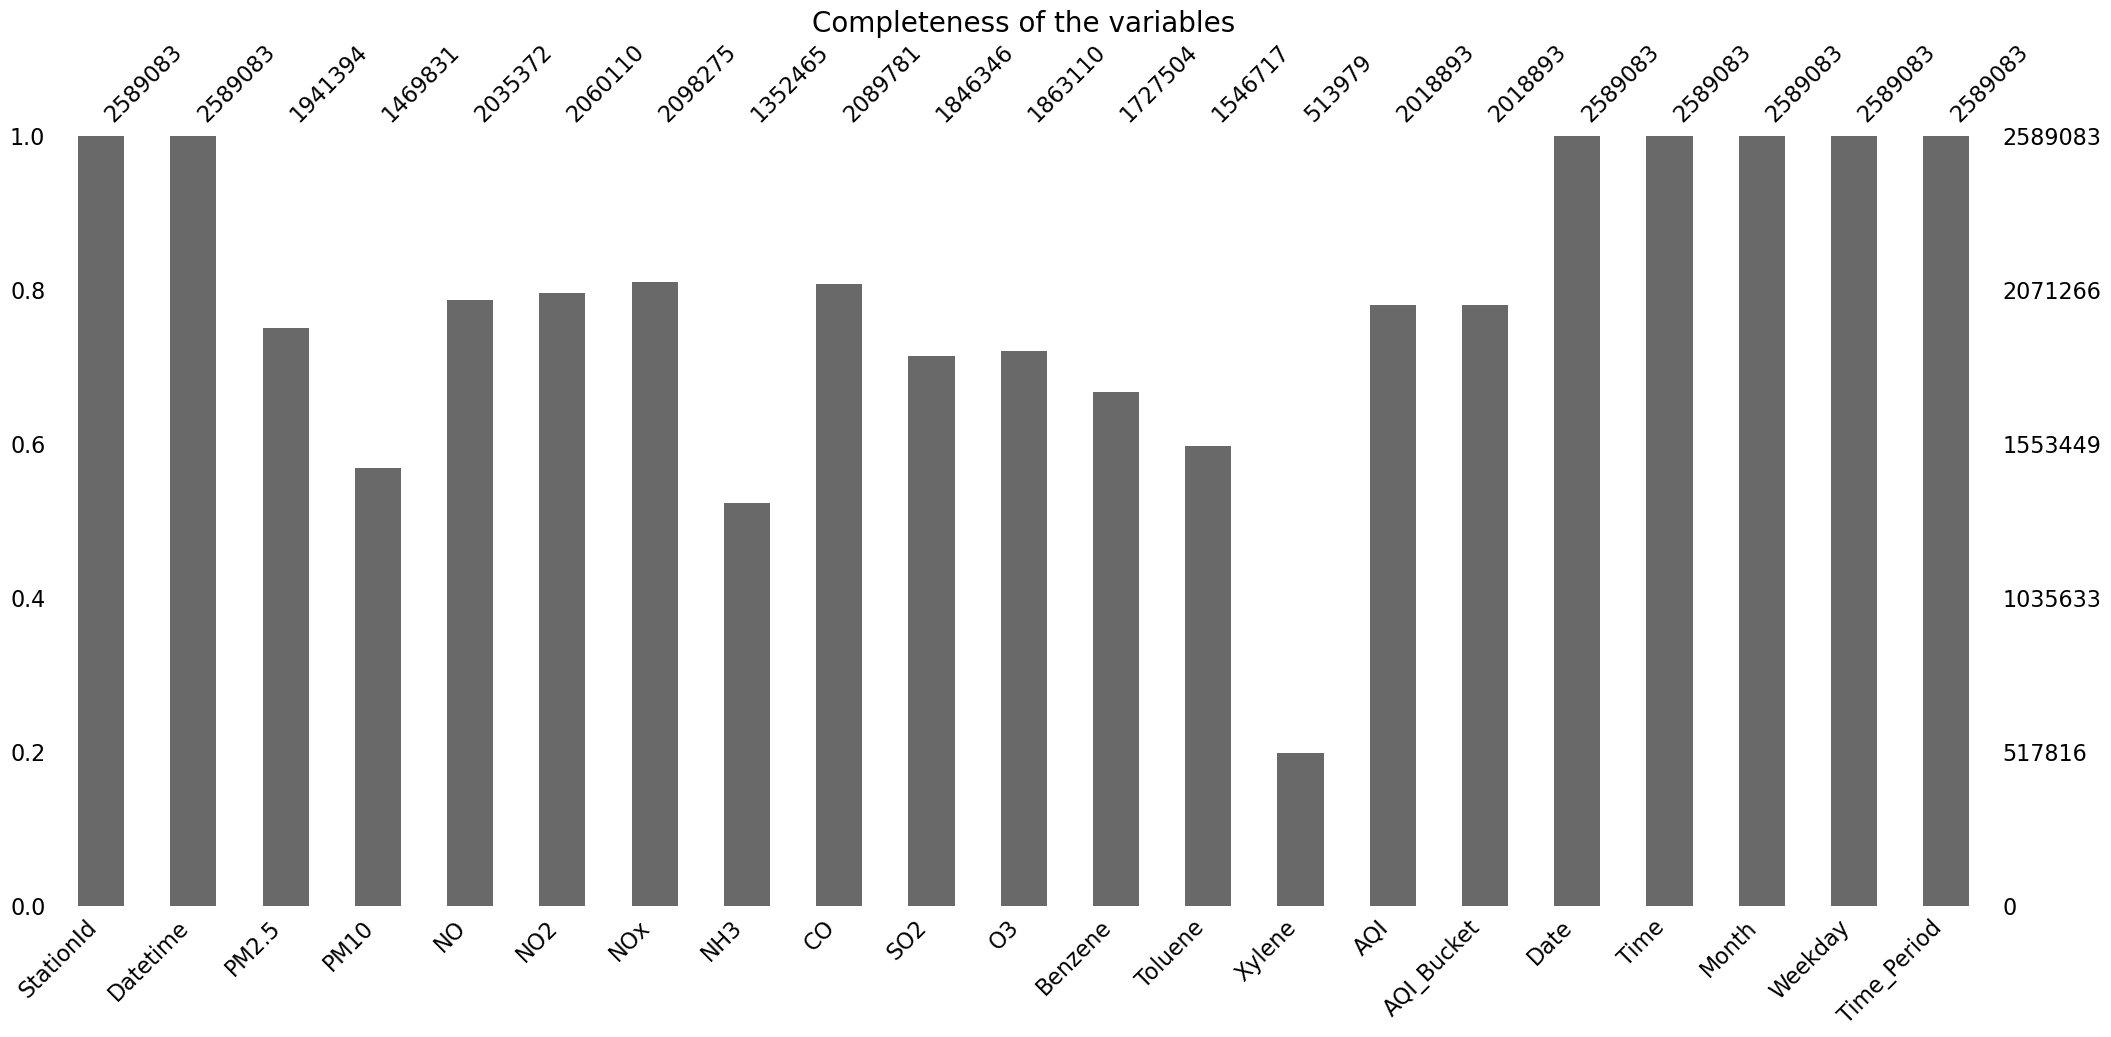

In [59]:
# using missingno library to analyze patterns in missing data
msno.bar(station_hour)
plt.title('Completeness of the variables', fontsize=20)
;

''

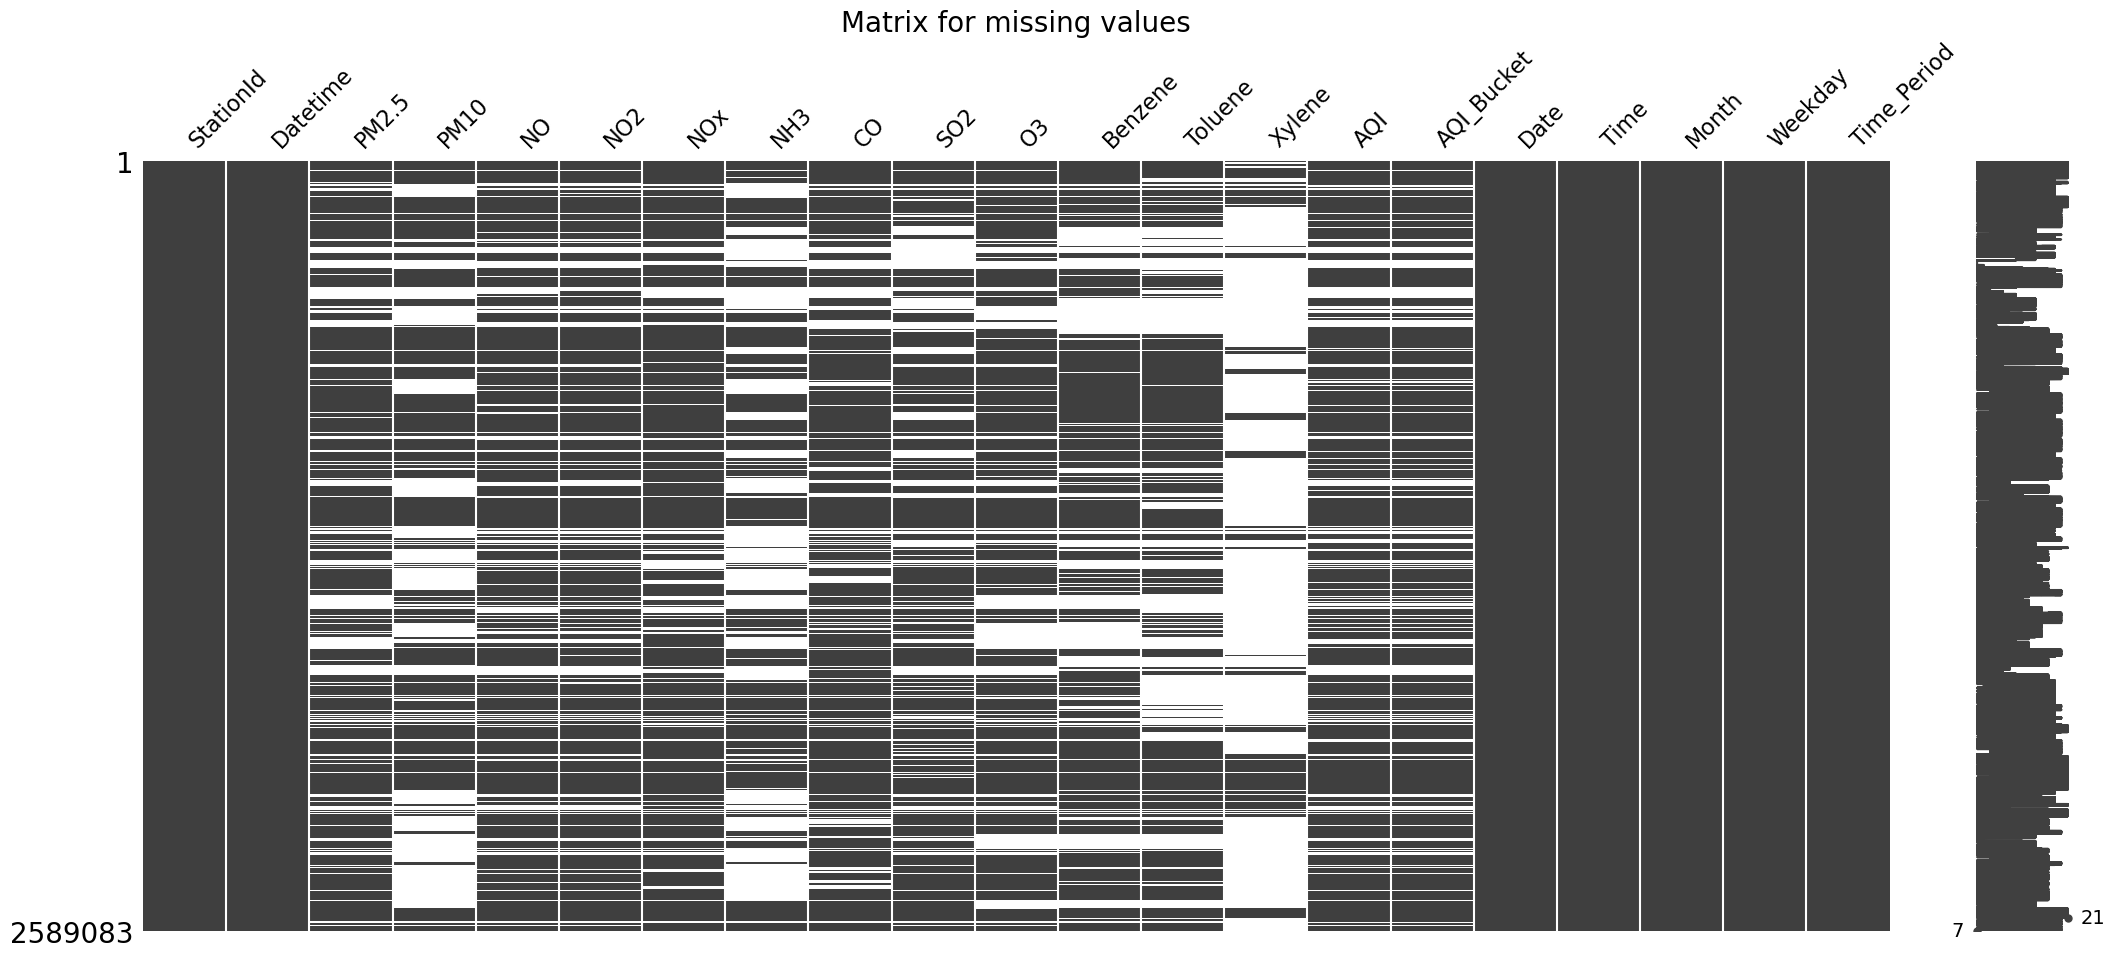

In [60]:
# looking for the bloos of missig data, similar pattern in different columns means that these datapoints were likely collected together
missing_values.style.background_gradient(cmap='Reds')
msno.matrix(station_hour)
plt.title('Matrix for missing values', fontsize = 20)
;

<Axes: >

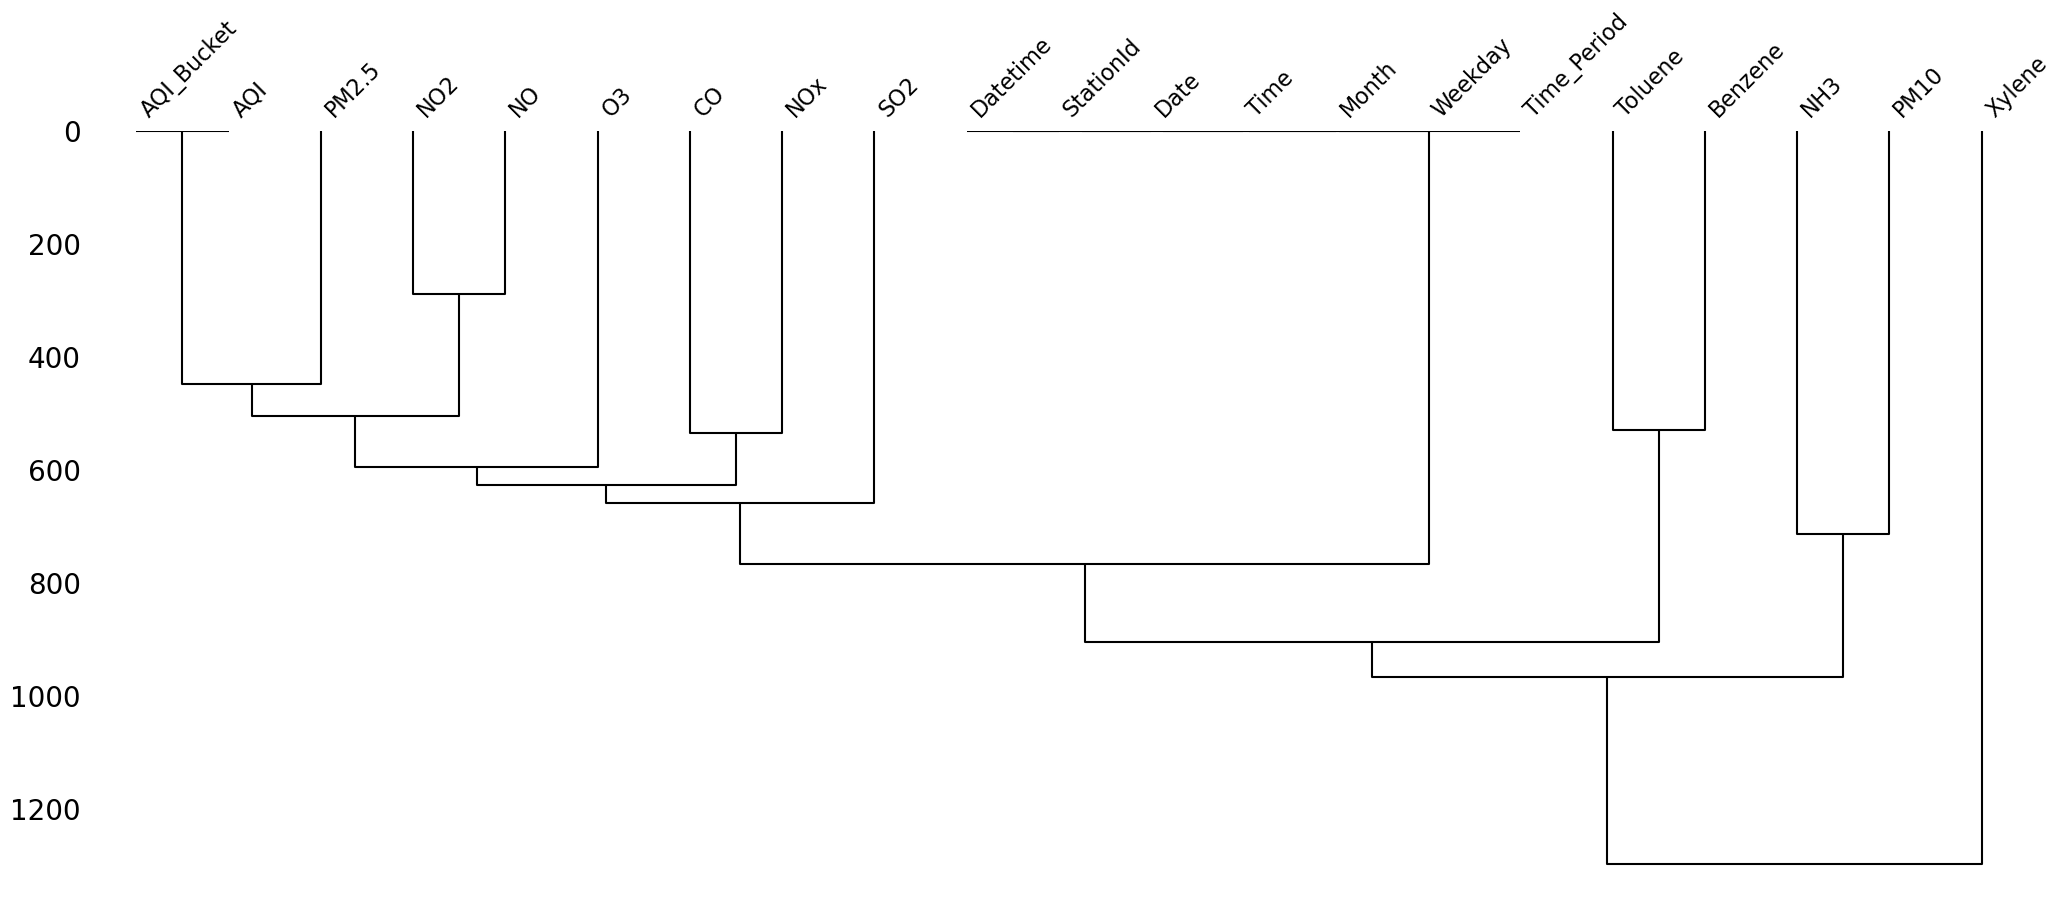

In [61]:
# this graph uses clustering to group variables that have similar missing values pattern
msno.dendrogram(station_hour)

**Simmilar patterns for missing values based on the dendogram**
- AQI_Bucket & AQI and PM2.5
- NO and NO2
- O3
- NOx and CO
- SO2
- PM10, NH3
- Touene and Benzene
- NH3 and PM10
- Xylene presents the most missing values

Since these variables present similar pattern in missing values, they should be filled in in similar way.

In [62]:
# overview of station dataset to merge with station_hour to have information about stations location (city, state) including status and station name
stations.head()

,StationId,StationName,City,State,Status
0,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
1,AP002,"Anand Kala Kshetram, Rajamahendravaram - APPCB",Rajamahendravaram,Andhra Pradesh,NaN
2,AP003,"Tirumala, Tirupati - APPCB",Tirupati,Andhra Pradesh,NaN
3,AP004,"PWD Grounds, Vijayawada - APPCB",Vijayawada,Andhra Pradesh,NaN
4,AP005,"GVM Corporation, Visakhapatnam - APPCB",Visakhapatnam,Andhra Pradesh,Active


In [63]:
stations['Status'].value_counts()

Status
Active      131
Inactive      2
Name: count, dtype: int64

In [64]:
station_hour = station_hour.merge(stations, on='StationId', how = 'inner')

In [65]:
station_hour['City'].value_counts()

City
Delhi                 1087388
Bengaluru              287564
Hyderabad              209831
Chennai                153648
Lucknow                146210
Mumbai                 131750
Kolkata                 75717
Jaipur                  74032
Gurugram                67804
Patna                   64031
Ahmedabad               48192
Visakhapatnam           35053
Thiruvananthapuram      29971
Amritsar                29269
Jorapokhar              28025
Amaravati               22784
Brajrajnagar            22468
Talcher                 22161
Guwahati                12002
Coimbatore               9229
Shillong                 7402
Chandigarh               7263
Bhopal                   6903
Kochi                    3854
Ernakulam                3852
Aizawl                   2680
Name: count, dtype: int64

In [66]:
station_hour['State'].value_counts()

State
Delhi             1087388
Karnataka          287564
Telangana          209831
Tamil Nadu         162877
Uttar Pradesh      146210
Maharashtra        131750
West Bengal         75717
Rajasthan           74032
Haryana             67804
Bihar               64031
Andhra Pradesh      57837
Gujarat             48192
Odisha              44629
Kerala              37677
Punjab              29269
Jharkhand           28025
Assam               12002
Meghalaya            7402
Chandigarh           7263
Madhya Pradesh       6903
Mizoram              2680
Name: count, dtype: int64

In [67]:
# exploring missing values for the variable with station status
inactive_stations = pd.DataFrame(station_hour['Status'].isna().groupby([
    station_hour['State'], 
    station_hour['City']
]).sum()).reset_index()

inactive_stations = inactive_stations.rename(columns={'Status':'Number of inactive stations'})
total_records = station_hour.groupby(['State', 'City']).size().reset_index(name='Total Records')
inactive_stations = inactive_stations.merge(
    total_records, 
    on=['State', 'City'], 
    how='left'
)
inactive_stations

,State,City,Number of inactive stations,Total Records
0,Andhra Pradesh,Amaravati,0,22784
1,Andhra Pradesh,Visakhapatnam,0,35053
2,Assam,Guwahati,0,12002
3,Bihar,Patna,0,64031
4,Chandigarh,Chandigarh,0,7263
5,Delhi,Delhi,0,1087388
6,Gujarat,Ahmedabad,0,48192
7,Haryana,Gurugram,0,67804
8,Jharkhand,Jorapokhar,0,28025
9,Karnataka,Bengaluru,0,287564


**Inactive stations are located in same state, in different cities. We need to check if these stations track the emissios or not**

In [68]:
station_hour[station_hour['City'].isin(('Ernakulam', 'Kochi'))].head()

,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,AQI_Bucket,Date,Time,Month,Weekday,Time_Period,StationName,City,State,Status
1660106,KL002,2020-01-22 13:00:00,33.83,78.25,130.28,7.63,137.91,103.77,2.02,NaN,...,NaN,2020-01-22,13,1,2,Day,"Kacheripady, Ernakulam - Kerala PCB",Ernakulam,Kerala,NaN
1660107,KL002,2020-01-22 14:00:00,41.00,87.00,128.78,7.77,136.52,102.78,2.10,NaN,...,NaN,2020-01-22,14,1,2,Day,"Kacheripady, Ernakulam - Kerala PCB",Ernakulam,Kerala,NaN
1660108,KL002,2020-01-22 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2020-01-22,15,1,2,Day,"Kacheripady, Ernakulam - Kerala PCB",Ernakulam,Kerala,NaN
1660109,KL002,2020-01-22 16:00:00,40.10,83.36,125.70,7.90,133.62,100.35,1.78,3.35,...,NaN,2020-01-22,16,1,2,Day,"Kacheripady, Ernakulam - Kerala PCB",Ernakulam,Kerala,NaN
1660110,KL002,2020-01-22 17:00:00,35.00,74.00,126.47,7.76,134.24,100.99,1.84,3.33,...,NaN,2020-01-22,17,1,2,Day,"Kacheripady, Ernakulam - Kerala PCB",Ernakulam,Kerala,NaN


**There are inactive stations in Kerala state in cities Ernakulam and Kochi, however they still provide records for emissions. Therefore, for these stations we may fill in missing values as `active`**

In [69]:
station_hour['Status'] = station_hour['Status'].fillna('active')

#### Missing values overview emissions

Exploring missing values and its time patterns to understand and reveal nature of missing data

In [70]:
# creating boolean values with informatio about missing values for summary table and visualization
station_hour.loc[:,'PM2.5_is_zero'] = (station_hour['PM2.5'].isna())

station_hour.loc[:,'NO_is_zero'] = (station_hour['NO'].isna())
station_hour.loc[:,'NO2_is_zero'] = (station_hour['NO2'].isna())

station_hour.loc[:,'O3_is_zero'] = (station_hour['O3'].isna())

station_hour.loc[:,'CO_is_zero'] = (station_hour['CO'].isna())
station_hour.loc[:,'NOx_is_zero'] = (station_hour['NOx'].isna())

station_hour.loc[:,'SO2_is_zero'] = (station_hour['SO2'].isna())

station_hour.loc[:,'Toluene_is_zero'] = (station_hour['Toluene'].isna())
station_hour.loc[:,'Benzene_is_zero'] = (station_hour['Benzene'].isna())

station_hour.loc[:,'PM10_is_zero'] = (station_hour['PM10'].isna())
station_hour.loc[:,'NH3_is_zero'] = (station_hour['NH3'].isna())

station_hour.loc[:,'Xylene_is_zero'] = (station_hour['Xylene'].isna())

In [71]:
# summary table representing dynamics of missing values for each emission in time
zeros_by_datetime = station_hour.groupby('Datetime')[['PM2.5_is_zero', 'NO_is_zero', 'NO2_is_zero', 'O3_is_zero', 'NOx_is_zero', 'CO_is_zero', 'SO2_is_zero',
                                                     'Toluene_is_zero', 'Benzene_is_zero', 'PM10_is_zero', 'NH3_is_zero', 'Xylene_is_zero']].sum()
zeros_by_datetime = zeros_by_datetime.reset_index()
zeros_by_datetime.head()

,Datetime,PM2.5_is_zero,NO_is_zero,NO2_is_zero,O3_is_zero,NOx_is_zero,CO_is_zero,SO2_is_zero,Toluene_is_zero,Benzene_is_zero,PM10_is_zero,NH3_is_zero,Xylene_is_zero
0,2015-01-01 01:00:00,12,2,1,5,0,4,4,6,5,13,10,11
1,2015-01-01 02:00:00,12,3,2,6,1,5,5,7,7,14,10,11
2,2015-01-01 03:00:00,12,2,2,7,1,4,5,7,7,14,10,11
3,2015-01-01 04:00:00,12,2,2,6,1,6,5,7,7,14,10,11
4,2015-01-01 05:00:00,12,2,2,7,1,4,5,7,7,13,10,11


In [72]:
# creating time variables(date, hour, month, weekday, time period) to explore missing values in different time dimensions
zeros_by_datetime['Date'] = zeros_by_datetime['Datetime'].dt.date

zeros_by_datetime['Hour'] = zeros_by_datetime['Datetime'].dt.hour

zeros_by_datetime['Month'] = zeros_by_datetime['Datetime'].dt.month

zeros_by_datetime['Weekday'] = zeros_by_datetime['Datetime'].dt.weekday

bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Day', 'Evening']
zeros_by_datetime['Time_Period'] = pd.cut(zeros_by_datetime['Hour'], bins=bins, labels=labels, right=False, include_lowest=True)

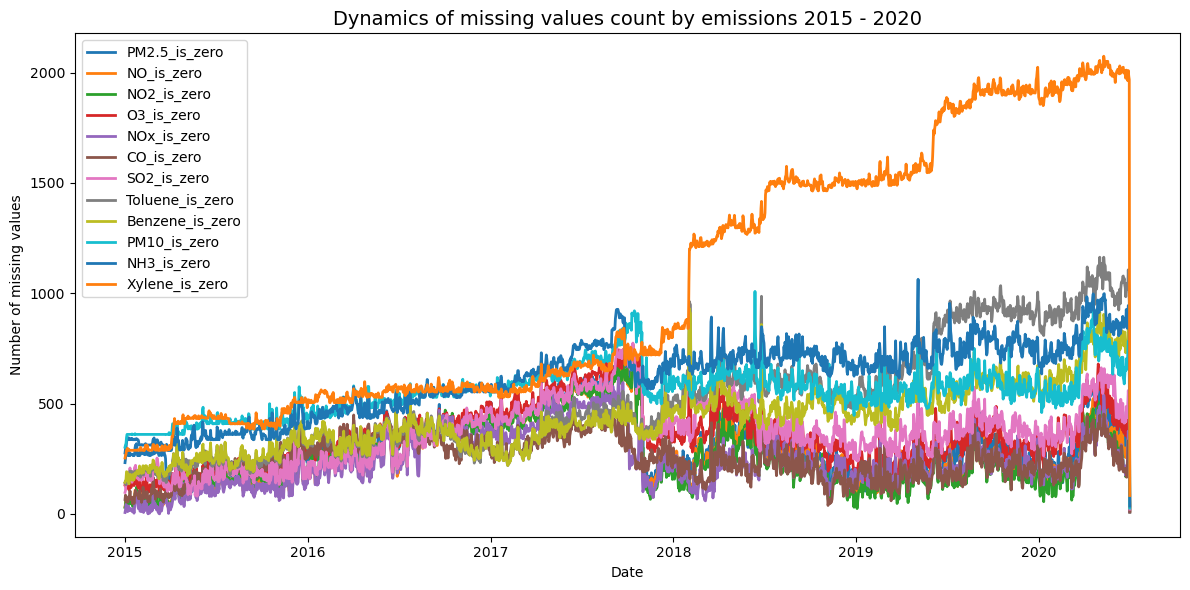

In [73]:
# visualizing missing values dynamics for date timeline for each emission
plt.figure(figsize=(12, 6))

df_plot = zeros_by_datetime.drop(columns=['Datetime', 'Hour', 'Month', 'Weekday', 'Time_Period'])

df_plot = pd.DataFrame(df_plot.groupby('Date').sum()).reset_index()
df_plot = df_plot.set_index('Date')

df_plot.plot(ax=plt.gca(), linewidth=2)

plt.title('Dynamics of missing values count by emissions 2015 - 2020', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of missing values')
plt.tight_layout()
plt.show()

***
- **In general, number of missing values has increased significantly in 2018, primarily because of the Xylene**
- **However, there is a positive trend in number of missing values increase over time**

In [74]:
#creating auxiliary datasets for exploring missing values dynamics in other time dimensions
#dataset with number of missing values for each month 
zeros_by_month = pd.DataFrame(zeros_by_datetime.groupby('Month')[['PM2.5_is_zero', 'NO_is_zero', 'NO2_is_zero', 'O3_is_zero', 'NOx_is_zero', 'CO_is_zero', 'SO2_is_zero',
                                                     'Toluene_is_zero', 'Benzene_is_zero', 'PM10_is_zero', 'NH3_is_zero', 'Xylene_is_zero']].sum()).reset_index()
zeros_by_month = zeros_by_month.set_index('Month')

#dataset with number of missing values for each weekday
zeros_by_weekday = pd.DataFrame(zeros_by_datetime.groupby('Weekday')[['PM2.5_is_zero', 'NO_is_zero', 'NO2_is_zero', 'O3_is_zero', 'NOx_is_zero', 'CO_is_zero', 'SO2_is_zero',
                                                     'Toluene_is_zero', 'Benzene_is_zero', 'PM10_is_zero', 'NH3_is_zero', 'Xylene_is_zero']].sum()).reset_index()
zeros_by_weekday = zeros_by_weekday.set_index('Weekday')

#dataset with number of missing values for each time period (night, morning, afternoon, evening)
zeros_by_time_period = pd.DataFrame(zeros_by_datetime.groupby('Time_Period')[['PM2.5_is_zero', 'NO_is_zero', 'NO2_is_zero', 'O3_is_zero', 'NOx_is_zero', 'CO_is_zero', 'SO2_is_zero',
                                                     'Toluene_is_zero', 'Benzene_is_zero', 'PM10_is_zero', 'NH3_is_zero', 'Xylene_is_zero']].sum()).reset_index()
zeros_by_time_period = zeros_by_time_period.set_index('Time_Period')

#dataset with number of missing values for each hour
zeros_by_hour = pd.DataFrame(zeros_by_datetime.groupby('Hour')[['PM2.5_is_zero', 'NO_is_zero', 'NO2_is_zero', 'O3_is_zero', 'NOx_is_zero', 'CO_is_zero', 'SO2_is_zero',
                                                     'Toluene_is_zero', 'Benzene_is_zero', 'PM10_is_zero', 'NH3_is_zero', 'Xylene_is_zero']].sum()).reset_index()
zeros_by_hour = zeros_by_hour.set_index('Hour')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29148\4232406089.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zeros_by_time_period = pd.DataFrame(zeros_by_datetime.groupby('Time_Period')[['PM2.5_is_zero', 'NO_is_zero', 'NO2_is_zero', 'O3_is_zero', 'NOx_is_zero', 'CO_is_zero', 'SO2_is_zero',


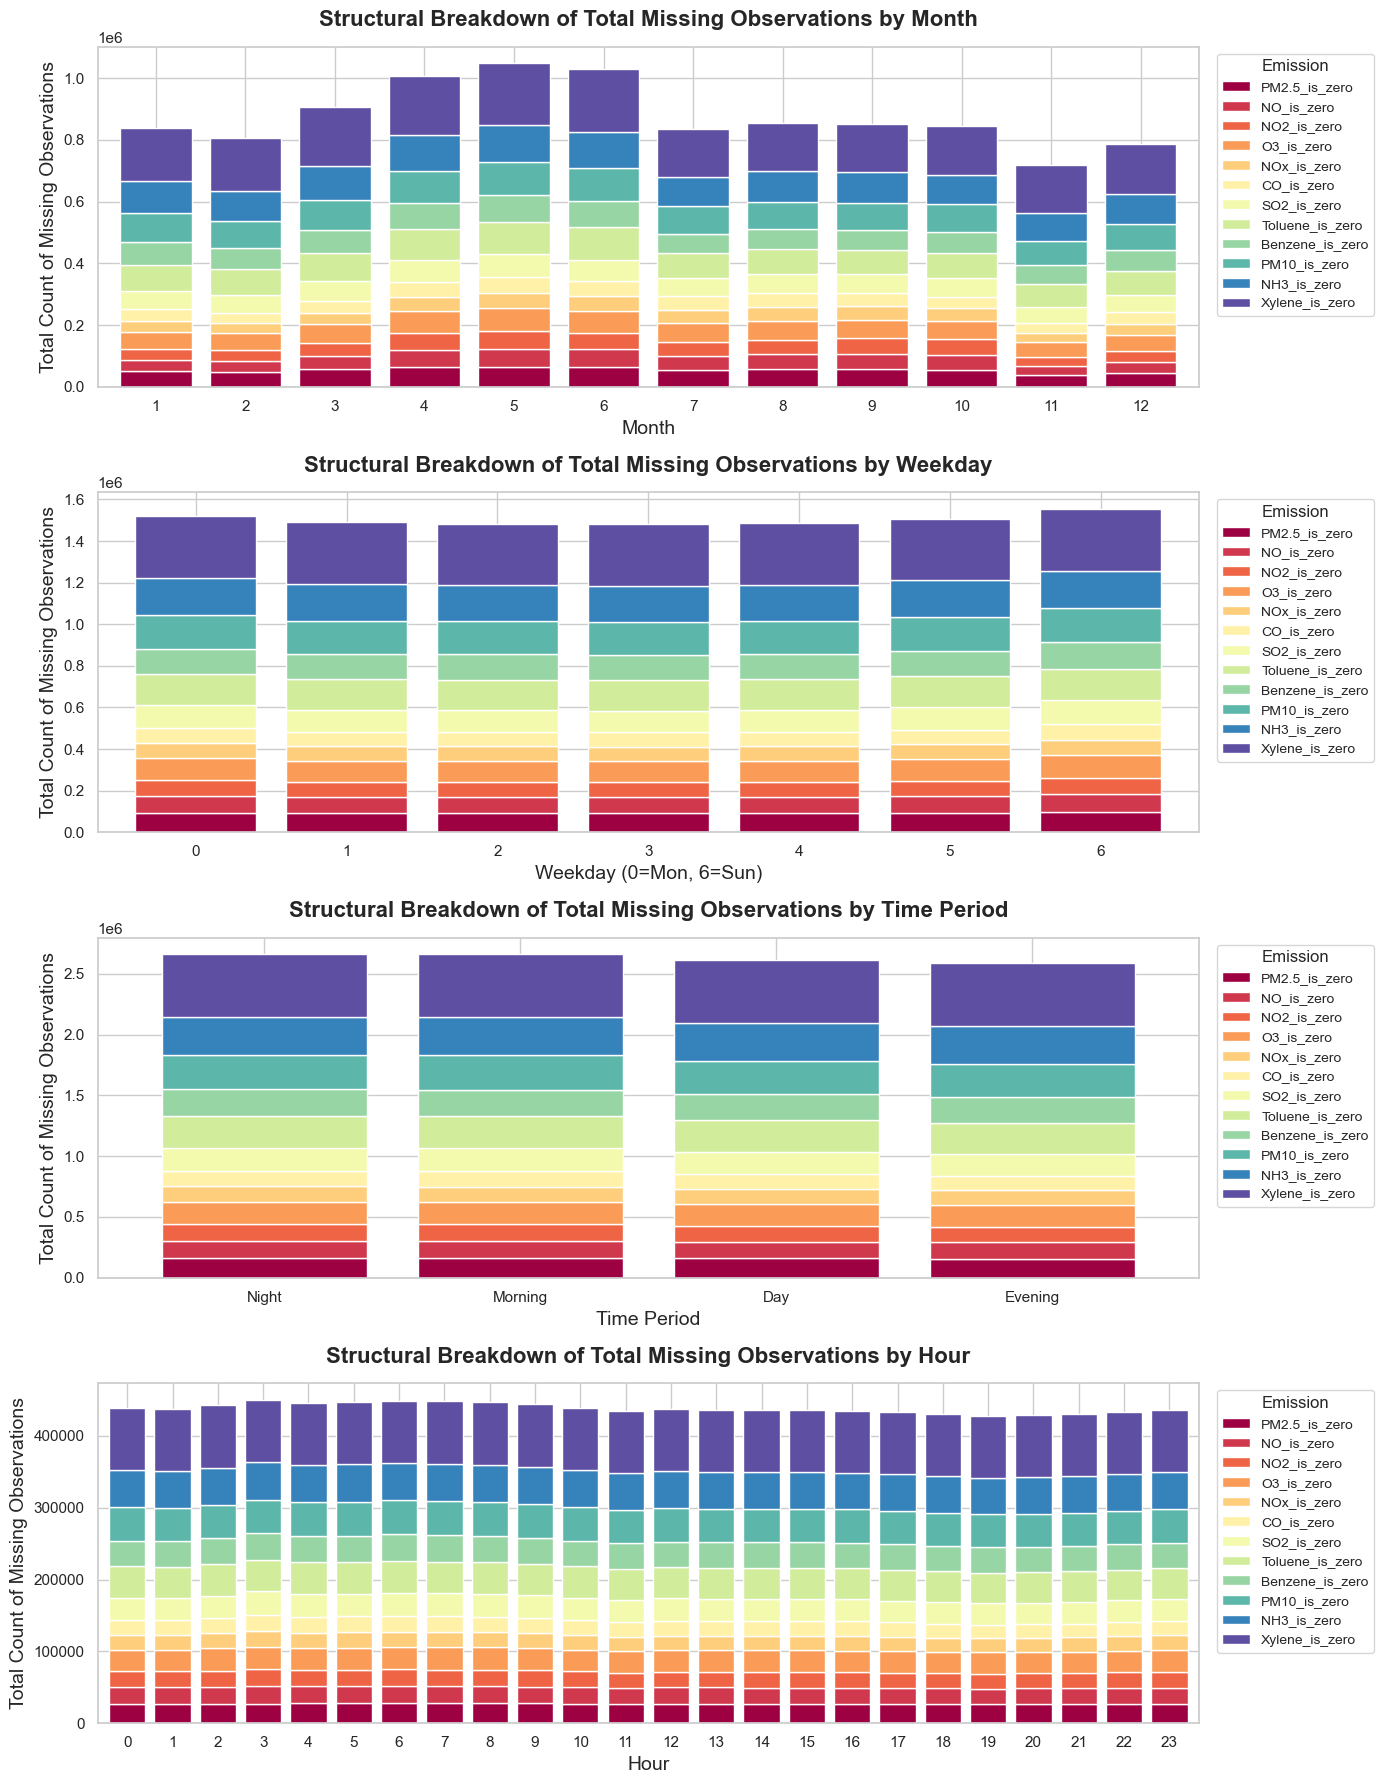

In [75]:
#graph for visualizing missing values dynamics for different time dimensions
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(
    nrows=4, 
    ncols=1, 
    figsize=(14, 18)
)

# Flatten the axes array for easier indexing (axes[0], axes[1], etc.)
axes = axes.flatten() 

# --- PLOT 1: MISSING VALUES BY MONTH (axes[0]) ---
zeros_by_month.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[0],
    colormap='Spectral',
    width=0.8
)

axes[0].set_title(
    'Structural Breakdown of Total Missing Observations by Month',
    fontsize=16, 
    fontweight='bold',
    pad=15
)
axes[0].set_xlabel('Month', fontsize=14)
axes[0].set_ylabel('Total Count of Missing Observations', fontsize=14)
axes[0].tick_params(axis='x', rotation=0)

axes[0].legend(
    title='Emission', 
    loc='upper left', 
    bbox_to_anchor=(1.01, 1),
    frameon=True, 
    ncol=1, 
    fontsize=10
)

# --- PLOT 2: MISSING VALUES BY WEEKDAY (axes[1]) ---
zeros_by_weekday.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[1],
    colormap='Spectral',
    width=0.8
)

axes[1].set_title(
    'Structural Breakdown of Total Missing Observations by Weekday',
    fontsize=16, 
    fontweight='bold',
    pad=15
)
axes[1].set_xlabel('Weekday (0=Mon, 6=Sun)', fontsize=14)
axes[1].set_ylabel('Total Count of Missing Observations', fontsize=14)
axes[1].tick_params(axis='x', rotation=0)

axes[1].legend(
    title='Emission', 
    loc='upper left', 
    bbox_to_anchor=(1.01, 1),
    frameon=True, 
    ncol=1, 
    fontsize=10
)

# --- PLOT 3: MISSING VALUES BY TIME PERIOD (axes[2]) ---
zeros_by_time_period.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[2],
    colormap='Spectral',
    width=0.8
)

axes[2].set_title(
    'Structural Breakdown of Total Missing Observations by Time Period',
    fontsize=16, 
    fontweight='bold',
    pad=15
)
axes[2].set_xlabel('Time Period', fontsize=14)
axes[2].set_ylabel('Total Count of Missing Observations', fontsize=14)
axes[2].tick_params(axis='x', rotation=0)

axes[2].legend(
    title='Emission', 
    loc='upper left', 
    bbox_to_anchor=(1.01, 1),
    frameon=True, 
    ncol=1, 
    fontsize=10
)

# --- PLOT 4: MISSING VALUES BY HOUR (axes[3]) ---
zeros_by_hour.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[3],
    colormap='Spectral',
    width=0.8
)

axes[3].set_title(
    'Structural Breakdown of Total Missing Observations by Hour',
    fontsize=16, 
    fontweight='bold',
    pad=15
)
axes[3].set_xlabel('Hour', fontsize=14)
axes[3].set_ylabel('Total Count of Missing Observations', fontsize=14)
axes[3].tick_params(axis='x', rotation=0)

axes[3].legend(
    title='Emission', 
    loc='upper left', 
    bbox_to_anchor=(1.01, 1),
    frameon=True, 
    ncol=1, 
    fontsize=10
)

plt.tight_layout()
plt.show()

**There is no temporal dependency in terms of Date, Month, Weekday, Time Period, Hour, since count are relatively equally distributed for these time variables.**

In [76]:
# table with missiong values for each enissions by cities 
df_zeros = station_hour.groupby('City')[['PM2.5_is_zero', 'NO_is_zero', 'NO2_is_zero', 'O3_is_zero', 'NOx_is_zero', 'CO_is_zero', 'SO2_is_zero',
                                                     'Toluene_is_zero', 'Benzene_is_zero', 'PM10_is_zero', 'NH3_is_zero', 'Xylene_is_zero']].sum()

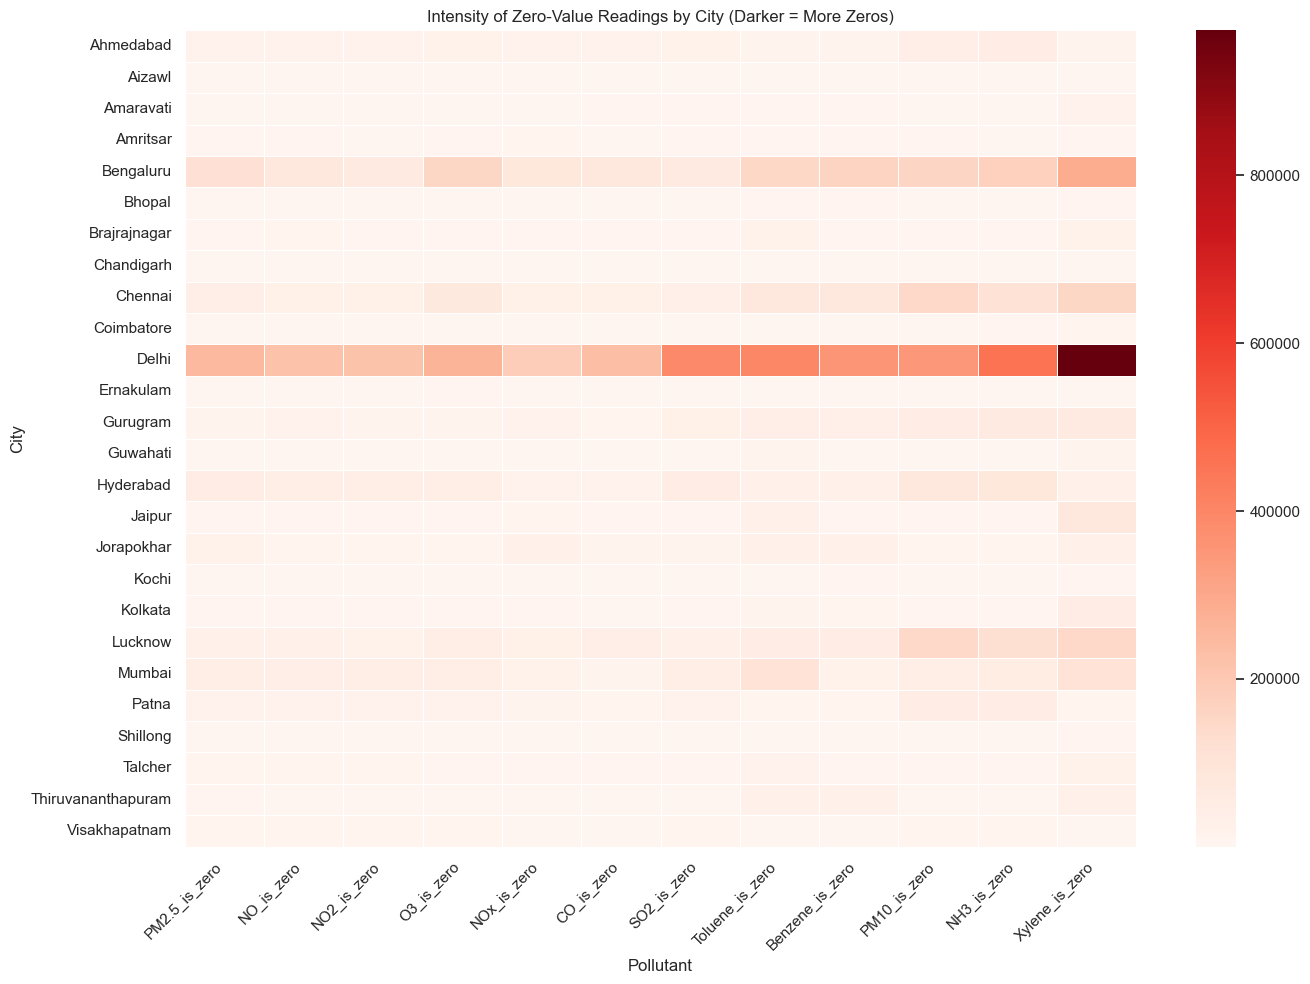

In [77]:
# Plotting the Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df_zeros, annot=False, cmap="Reds", linewidths=.5)
plt.title("Intensity of Zero-Value Readings by City (Darker = More Zeros)")
plt.xlabel("Pollutant")
plt.ylabel("City")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Geographical Dependency**
- Significant Outlier Detected: Delhi is a massive outlier, exhibiting a disproportionately high frequency of zero-value readings across multiple pollutants, particularly Xylene (which shows >600k zero records)

Start working on missing values with emissions. So that later we can calculate missing values in AQI and AQI_bucket based on the emissions tracked.

#### Strategy for filling in missing values

In [78]:
station_hour.head()

,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,NO2_is_zero,O3_is_zero,CO_is_zero,NOx_is_zero,SO2_is_zero,Toluene_is_zero,Benzene_is_zero,PM10_is_zero,NH3_is_zero,Xylene_is_zero
0,AP001,2017-11-24 17:00:00,60.50,98.00,2.35,30.80,18.25,8.50,0.1,11.85,...,False,False,False,False,False,False,False,False,False,False
1,AP001,2017-11-24 18:00:00,65.50,111.25,2.70,24.20,15.07,9.77,0.1,13.17,...,False,False,False,False,False,False,False,False,False,False
2,AP001,2017-11-24 19:00:00,80.00,132.00,2.10,25.18,15.15,12.02,0.1,12.08,...,False,False,False,False,False,False,False,False,False,False
3,AP001,2017-11-24 20:00:00,81.50,133.25,1.95,16.25,10.23,11.58,0.1,10.47,...,False,False,False,False,False,False,False,False,False,False
4,AP001,2017-11-24 21:00:00,75.25,116.00,1.43,17.48,10.43,12.03,0.1,9.12,...,False,False,False,False,False,False,False,False,False,False


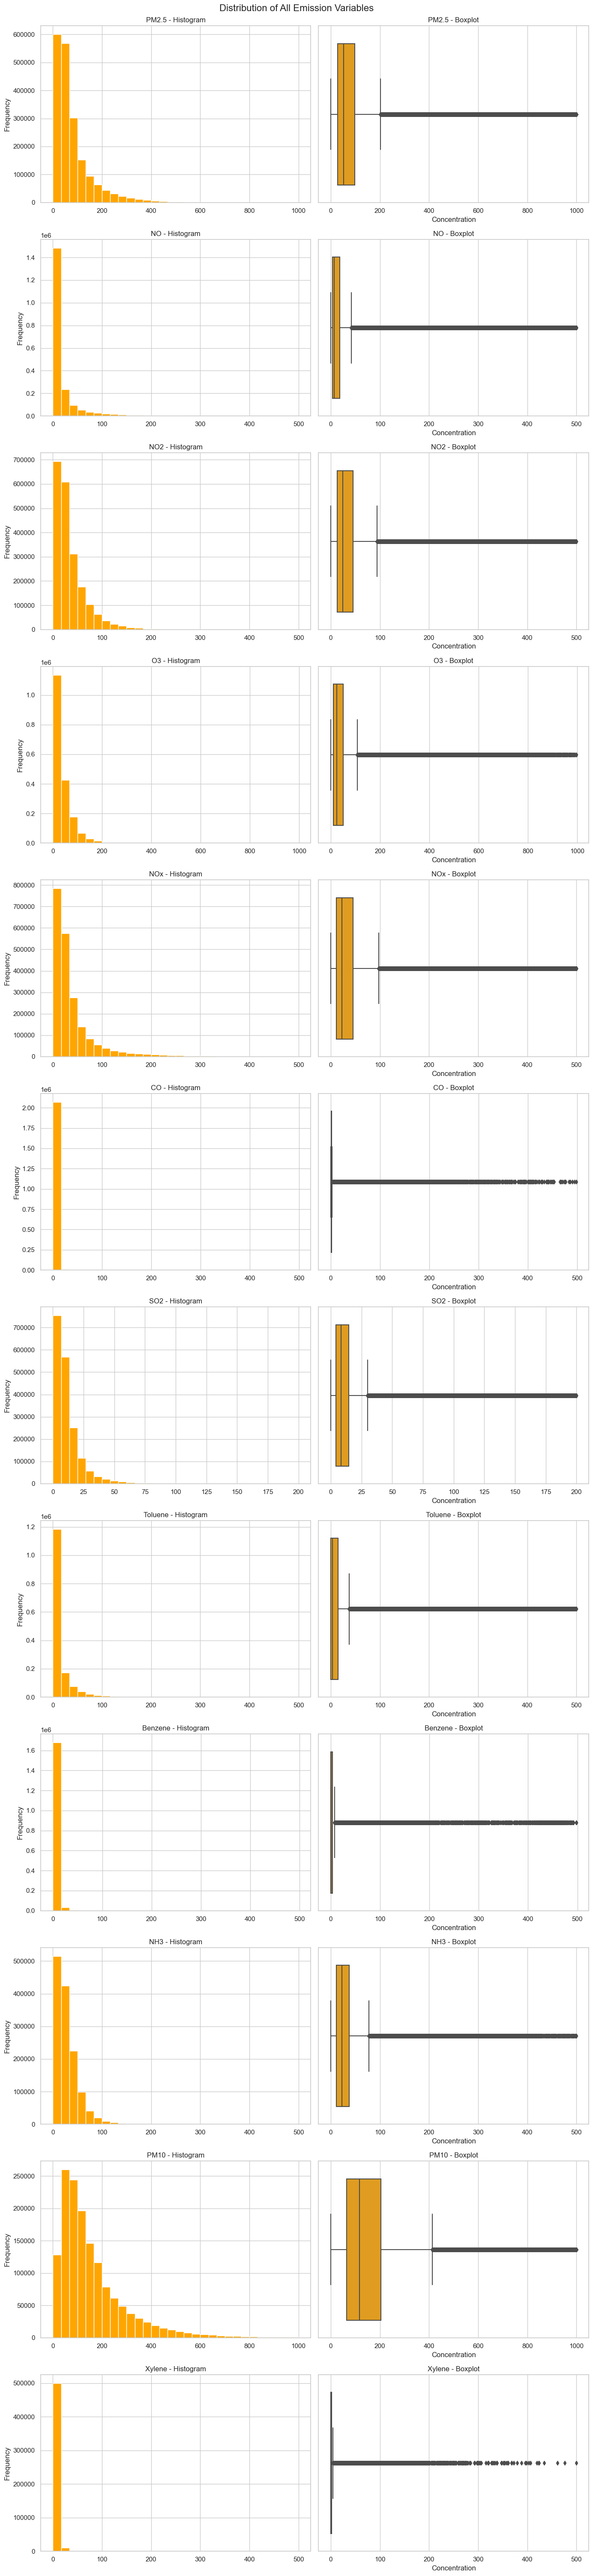

In [79]:
pollutants = ['PM2.5', 'NO', 'NO2', 'O3', 'NOx', 'CO', 'SO2', 'Toluene', 'Benzene', 'NH3', 'PM10', 'Xylene']

# Create a figure with a row for each pollutant and 2 columns (Hist + Box)
# figsize height is scaled by the number of pollutants to ensure it's readable
fig, axes = plt.subplots(nrows=len(pollutants), ncols=2, figsize=(14, 5 * len(pollutants)))

for i, col in enumerate(pollutants):
    # 1. Histogram (Left)
    station_hour[col].hist(ax=axes[i, 0], edgecolor='white', color='orange', bins=30)
    axes[i, 0].set_title(f'{col} - Histogram')
    axes[i, 0].set_ylabel('Frequency')
    
    # 2. Boxplot (Right)
    sns.boxplot(x=station_hour[col], ax=axes[i, 1], color='orange')
    axes[i, 1].set_title(f'{col} - Boxplot')
    axes[i, 1].set_xlabel('Concentration')

plt.tight_layout()
plt.suptitle('Distribution of All Emission Variables', y=1.002, fontsize=16)
plt.show()

**For variables**
- There is high volatility of the data
- There are a lot of outliers
- No special time- or spatial- dependencies (na values are relatively equally destributed among states, cities and temporal variables)
Therefore, to fill in the missing values it is better to use median value typical for specific station 

In [80]:
#cheking number of missing values remaining for each variable
print(f"Number of missing values for PM2.5 emissions {station_hour['PM2.5'].isna().sum()}")

print(f"Number of missing values for NO emissions {station_hour['NO'].isna().sum()}")
print(f"Number of missing values for NO2 emissions {station_hour['NO2'].isna().sum()}")

print(f"Number of missing values for O3 emissions {station_hour['O3'].isna().sum()}")

print(f"Number of missing values for NOx emissions {station_hour['NOx'].isna().sum()}")
print(f"Number of missing values for CO emissions {station_hour['CO'].isna().sum()}")

print(f"Number of missing values for SO2 emissions {station_hour['SO2'].isna().sum()}")

print(f"Number of missing values for Toluene emissions {station_hour['Toluene'].isna().sum()}")
print(f"Number of missing values for Benzene emissions {station_hour['Benzene'].isna().sum()}")

print(f"Number of missing values for PM10 emissions {station_hour['PM10'].isna().sum()}")
print(f"Number of missing values for NH3 emissions {station_hour['NH3'].isna().sum()}")

Number of missing values for PM2.5 emissions 647689
Number of missing values for NO emissions 553711
Number of missing values for NO2 emissions 528973
Number of missing values for O3 emissions 725973
Number of missing values for NOx emissions 490808
Number of missing values for CO emissions 499302
Number of missing values for SO2 emissions 742737
Number of missing values for Toluene emissions 1042366
Number of missing values for Benzene emissions 861579
Number of missing values for PM10 emissions 1119252
Number of missing values for NH3 emissions 1236618


In [81]:
#station_hour = station_hour.sort_values(by=['StationId', 'Datetime'])
station_hour = station_hour.set_index('Datetime')

cols_to_fix = ['PM2.5', 'NO', 'NO2', 'O3', 'NOx', 'CO', 'SO2', 'Toluene', 'Benzene', 'PM10', 'NH3']

for col in cols_to_fix:
    if col in station_hour.columns:
        station_hour[col] = station_hour.groupby('StationId')[col].transform(
            lambda x: x.interpolate(method='time', limit=3)
        )

station_hour = station_hour.reset_index()

In [82]:
station_hour = station_hour.sort_values(['StationId', 'Datetime'])

for col in cols_to_fix:
    if col not in station_hour.columns:
        continue
    
    # 2.1 Forward Fill (Limit=6) - As per your snippet
    station_hour[col] = station_hour.groupby('StationId')[col].ffill(limit=6)
    
    # 2.2 Fill with value from 24 hours ago (Daily Cycle)
    station_hour[col] = station_hour[col].fillna(
        station_hour.groupby('StationId')[col].shift(24)
    )
    
    # 2.3 Fill with value from 168 hours ago (Weekly Cycle) - ADDED
    station_hour[col] = station_hour[col].fillna(
        station_hour.groupby('StationId')[col].shift(168)
    )
    
    # 2.4 Fill with Station's Monthly Average for that specific hour
    station_hour[col] = station_hour[col].fillna(
        station_hour.groupby(['StationId', 'Month', 'Time'])[col].transform('mean')
    )

In [83]:
# 3.1 City Median
if 'City' in station_hour.columns:
    for col in cols_to_fix:
        if col in station_hour.columns:
            station_hour[col] = station_hour[col].fillna(
                station_hour.groupby(['City', 'Datetime'])[col].transform('median')
            )

# 3.2 State Median
if 'State' in station_hour.columns:
    for col in cols_to_fix:
        if col in station_hour.columns:
            station_hour[col] = station_hour[col].fillna(
                station_hour.groupby(['State', 'Datetime'])[col].transform('median')
            )

# 3.3 Global Median (Final Safety Net)
for col in cols_to_fix:
    if col in station_hour.columns:
        station_hour[col] = station_hour[col].fillna(station_hour[col].median())

In [84]:
#cheking number of missing values remaining for each variable
print(f"Number of missing values for PM2.5 emissions {station_hour['PM2.5'].isna().sum()}")

print(f"Number of missing values for NO emissions {station_hour['NO'].isna().sum()}")
print(f"Number of missing values for NO2 emissions {station_hour['NO2'].isna().sum()}")

print(f"Number of missing values for O3 emissions {station_hour['O3'].isna().sum()}")

print(f"Number of missing values for NOx emissions {station_hour['NOx'].isna().sum()}")
print(f"Number of missing values for CO emissions {station_hour['CO'].isna().sum()}")

print(f"Number of missing values for SO2 emissions {station_hour['SO2'].isna().sum()}")

print(f"Number of missing values for Toluene emissions {station_hour['Toluene'].isna().sum()}")
print(f"Number of missing values for Benzene emissions {station_hour['Benzene'].isna().sum()}")

print(f"Number of missing values for PM10 emissions {station_hour['PM10'].isna().sum()}")
print(f"Number of missing values for NH3 emissions {station_hour['NH3'].isna().sum()}")

Number of missing values for PM2.5 emissions 0
Number of missing values for NO emissions 0
Number of missing values for NO2 emissions 0
Number of missing values for O3 emissions 0
Number of missing values for NOx emissions 0
Number of missing values for CO emissions 0
Number of missing values for SO2 emissions 0
Number of missing values for Toluene emissions 0
Number of missing values for Benzene emissions 0
Number of missing values for PM10 emissions 0
Number of missing values for NH3 emissions 0


In [85]:
missing_values= missing_values_table(station_hour)
missing_values.style.background_gradient(cmap='Reds')

Your selected dataframe has 37 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Xylene,2075104,80.100000
AQI,570190,22.000000
AQI_Bucket,570190,22.000000


**The variable Xylene contains 80% of missing values, therefore it won't be accurate to impute missing values in this case. Moreover, this pollutant is irrelevant and do not participate in the AQI calculation. Thus, we can drop this variable to continue working with data without creating noise.**

In [86]:
# dropping irrelevat variable `Xylene`
station_hour = station_hour.drop(columns='Xylene')

#### AQI calculation

We calculate AQI using following methodology:

link - https://www.kaggle.com/code/rohanrao/calculating-aqi-air-quality-index-tutorial?scriptVersionId=41199538

In [87]:
station_hour["PM10_24hr_avg"] = station_hour.groupby("StationId")["PM10"].rolling(window = 24, min_periods = 16).mean().values
station_hour["PM2.5_24hr_avg"] = station_hour.groupby("StationId")["PM2.5"].rolling(window = 24, min_periods = 16).mean().values
station_hour["SO2_24hr_avg"] = station_hour.groupby("StationId")["SO2"].rolling(window = 24, min_periods = 16).mean().values
station_hour["NOx_24hr_avg"] = station_hour.groupby("StationId")["NOx"].rolling(window = 24, min_periods = 16).mean().values
station_hour["NH3_24hr_avg"] = station_hour.groupby("StationId")["NH3"].rolling(window = 24, min_periods = 16).mean().values
station_hour["CO_8hr_max"] = station_hour.groupby("StationId")["CO"].rolling(window = 8, min_periods = 1).max().values
station_hour["O3_8hr_max"] = station_hour.groupby("StationId")["O3"].rolling(window = 8, min_periods = 1).max().values

In [88]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

station_hour["PM2.5_SubIndex"] = station_hour["PM2.5_24hr_avg"].apply(lambda x: get_PM25_subindex(x))

In [89]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

station_hour["PM10_SubIndex"] = station_hour["PM10_24hr_avg"].apply(lambda x: get_PM10_subindex(x))

In [90]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

station_hour["SO2_SubIndex"] = station_hour["SO2_24hr_avg"].apply(lambda x: get_SO2_subindex(x))

In [91]:
## NOx Sub-Index calculation
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

station_hour["NOx_SubIndex"] = station_hour["NOx_24hr_avg"].apply(lambda x: get_NOx_subindex(x))

In [92]:
## NH3 Sub-Index calculation
def get_NH3_subindex(x):
    if x <= 200:
        return x * 50 / 200
    elif x <= 400:
        return 50 + (x - 200) * 50 / 200
    elif x <= 800:
        return 100 + (x - 400) * 100 / 400
    elif x <= 1200:
        return 200 + (x - 800) * 100 / 400
    elif x <= 1800:
        return 300 + (x - 1200) * 100 / 600
    elif x > 1800:
        return 400 + (x - 1800) * 100 / 600
    else:
        return 0

station_hour["NH3_SubIndex"] = station_hour["NH3_24hr_avg"].apply(lambda x: get_NH3_subindex(x))

In [93]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

station_hour["CO_SubIndex"] = station_hour["CO_8hr_max"].apply(lambda x: get_CO_subindex(x))

In [94]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

station_hour["O3_SubIndex"] = station_hour["O3_8hr_max"].apply(lambda x: get_O3_subindex(x))

In [95]:
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.nan

station_hour["Checks"] = (station_hour["PM2.5_SubIndex"] > 0).astype(int) + \
                (station_hour["PM10_SubIndex"] > 0).astype(int) + \
                (station_hour["SO2_SubIndex"] > 0).astype(int) + \
                (station_hour["NOx_SubIndex"] > 0).astype(int) + \
                (station_hour["NH3_SubIndex"] > 0).astype(int) + \
                (station_hour["CO_SubIndex"] > 0).astype(int) + \
                (station_hour["O3_SubIndex"] > 0).astype(int)

station_hour["AQI_calculated"] = round(station_hour[["PM2.5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", "NOx_SubIndex",
                                 "NH3_SubIndex", "CO_SubIndex", "O3_SubIndex"]].max(axis = 1))
station_hour.loc[station_hour["PM2.5_SubIndex"] + station_hour["PM10_SubIndex"] <= 0, "AQI_calculated"] = np.nan
station_hour.loc[station_hour.Checks < 3, "AQI_calculated"] = np.nan

station_hour["AQI_bucket_calculated"] = station_hour["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
station_hour[~station_hour.AQI_calculated.isna()].head(10)

,Datetime,StationId,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NOx_SubIndex,NH3_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
15,2017-11-25 08:00:00,AP001,93.50,142.75,2.025,24.515,14.685,8.765,0.1,14.025000,...,153.281250,112.322917,14.249609,15.439453,2.828672,15.0,131.617647,7,153.0,Moderate
16,2017-11-25 09:00:00,AP001,104.00,148.50,1.930,23.000,13.750,9.800,0.1,15.300000,...,158.774510,113.500000,14.536397,15.542279,2.806397,5.0,125.911765,7,159.0,Moderate
17,2017-11-25 10:00:00,AP001,94.50,142.00,1.330,16.250,9.750,9.650,0.1,17.000000,...,161.898148,114.305556,14.909375,15.355903,2.784514,5.0,153.279412,7,162.0,Moderate
18,2017-11-25 11:00:00,AP001,82.75,126.50,1.470,14.830,9.070,9.700,0.1,15.400000,...,162.631579,114.482456,15.137829,15.144408,2.765592,5.0,173.411765,7,173.0,Moderate
19,2017-11-25 12:00:00,AP001,79.00,124.00,5.300,21.150,15.530,9.400,0.1,17.533333,...,162.666667,114.558333,15.476771,15.357812,2.744813,5.0,183.529412,7,184.0,Moderate
20,2017-11-25 13:00:00,AP001,73.75,120.50,3.325,17.375,11.940,8.400,0.1,19.666667,...,161.865079,114.515873,15.910417,15.337202,2.714107,5.0,187.132353,7,187.0,Moderate
21,2017-11-25 14:00:00,AP001,68.50,117.00,1.350,13.600,8.350,7.400,0.1,21.800000,...,160.340909,114.371212,16.425852,15.114489,2.674830,5.0,190.735294,7,191.0,Moderate
22,2017-11-25 15:00:00,AP001,69.25,112.25,1.520,11.800,7.550,9.250,0.1,21.380000,...,159.057971,114.101449,16.873641,14.867663,2.659076,5.0,190.735294,7,191.0,Moderate
23,2017-11-25 16:00:00,AP001,70.00,107.00,2.800,30.330,18.400,6.150,0.1,18.900000,...,157.986111,113.708333,17.154948,15.206510,2.612344,5.0,190.735294,7,191.0,Moderate
24,2017-11-25 17:00:00,AP001,72.75,120.25,1.500,26.720,15.450,10.780,0.1,16.030000,...,159.687500,114.326389,17.372656,15.060677,2.636094,5.0,190.735294,7,191.0,Moderate


In [96]:
missing_values= missing_values_table(station_hour)
missing_values.style.background_gradient(cmap='Reds')

Your selected dataframe has 53 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
AQI,570190,22.000000
AQI_Bucket,570190,22.000000
PM10_24hr_avg,1650,0.100000
PM2.5_24hr_avg,1650,0.100000
SO2_24hr_avg,1650,0.100000
NOx_24hr_avg,1650,0.100000
NH3_24hr_avg,1650,0.100000
AQI_calculated,1650,0.100000
AQI_bucket_calculated,1650,0.100000


In [97]:
# dropping irrelevant columns 
station_hour = station_hour.drop(columns=['PM10_24hr_avg', 'PM2.5_24hr_avg', 'SO2_24hr_avg', 'NOx_24hr_avg', 'NH3_24hr_avg'])

#### AQI Formula Accuracy Validation

To evaluate the quality of our manual AQI calculation, we compare our results with the station's reference values using a filtered subset of data.

**Filtering Logic ("Valid Validation Set"):**
We only include timestamps where the station had sufficient data for a reliable calculation:
* ✅ PM2.5 or PM10 data is available.
* ✅ Data exists for at least 3 out of 7 pollutants.
* ✅ The station originally calculated the AQI (Target exists).

This allows us to eliminate errors related to missing sensor data and verify the pure mathematical correctness of the formula.

In [98]:
pollutant_flags = [
    'PM2.5_is_zero', 'PM10_is_zero', 'SO2_is_zero', 
    'NOx_is_zero', 'NH3_is_zero', 'CO_is_zero', 'O3_is_zero'
]

# Forming validity conditions according to the methodology (for ORIGINAL data)

# Condition 1: At least one PM (PM2.5 or PM10) is present
condition_pm_present = (~station_hour['PM2.5_is_zero']) | (~station_hour['PM10_is_zero'])

# Condition 2: At least 3 of the 7 indicators are present
# Sum the number (of real data) in the row
present_count = (~station_hour[pollutant_flags]).sum(axis=1)
condition_min_3 = present_count >= 3

# Condition 3: The original AQI must have existed too
condition_aqi_exists = station_hour['AQI'].notna()

# Collecting the "Golden Sample" (Valid Validation Set)
# These are the rows where the AQI was calculated honestly by the station, and the data for this was
valid_mask = condition_pm_present & condition_min_3 & condition_aqi_exists

# Select data for comparison
y_true = station_hour.loc[valid_mask, 'AQI']
y_pred = station_hour.loc[valid_mask, 'AQI_calculated']

# Calculating quality metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"Number of objects for validation: {valid_mask.sum()}")
print(f"R2 Score (accuracy of formula calculation): {r2:.4f}")
print(f"MAE (mean absolute error): {mae:.2f}")

Number of objects for validation: 1964352
R2 Score (accuracy of formula calculation): 0.9513
MAE (mean absolute error): 7.00


**According to the quality metrics the calculated AQI index is highly accurate presenting 95% of R-squared. And in general calculated AQI differs from initial AQI by 7 index points.** 

**The AQI calculation validation was conducted on those data points that were not affected by missing data imputation and were available initially and satisfy AQI calculatio methodology mentioned before.**

In [99]:
# filling in missing values with validated AQI calculation
station_hour['AQI_final'] = station_hour['AQI'].fillna(station_hour['AQI_calculated'])
station_hour['AQI_bucket_final'] = station_hour['AQI_Bucket'].fillna(station_hour['AQI_bucket_calculated'])

In [100]:
missing_values= missing_values_table(station_hour)
missing_values.style.background_gradient(cmap='Reds')

Your selected dataframe has 50 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
AQI,570190,22.000000
AQI_Bucket,570190,22.000000
AQI_calculated,1650,0.100000
AQI_bucket_calculated,1650,0.100000
AQI_final,1650,0.100000
AQI_bucket_final,1650,0.100000


In [101]:
df = station_hour

In [102]:
station_hour = station_hour.drop(columns=['AQI', 'AQI_Bucket', 'AQI_calculated', 'AQI_bucket_calculated'])

# deleting irrelevant columns 
patterns = ['_is_zero', '_max', '_SubIndex']
cols_to_drop = [col for col in df.columns if any(p in col for p in patterns)]
station_hour = station_hour.drop(columns=cols_to_drop)

station_hour = station_hour.drop(columns=['Checks'])

In [103]:
# final dataset and features
station_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2589083 entries, 0 to 2589082
Data columns (total 24 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Datetime          datetime64[ns]
 1   StationId         object        
 2   PM2.5             float64       
 3   PM10              float64       
 4   NO                float64       
 5   NO2               float64       
 6   NOx               float64       
 7   NH3               float64       
 8   CO                float64       
 9   SO2               float64       
 10  O3                float64       
 11  Benzene           float64       
 12  Toluene           float64       
 13  Date              object        
 14  Time              int32         
 15  Month             int32         
 16  Weekday           int32         
 17  Time_Period       category      
 18  StationName       object        
 19  City              object        
 20  State             object        
 21  Status  

#### Data Preparation Summary
- *Selection:* Prioritized station_hour (hourly data per station) for granular analysis of pollution profiles and merged it with stations data to add geospatial metadata (City, State, Status).

- *Engineering:* Converted Datetime to objects, extracted temporal features (Date, Time, Month, Weekday), and binned hours into Time_Period (Night, Morning, Day, Evening).

- *Cleaning:* Filled missing Status for 'Ernakulam' and 'Kochi' stations as 'Active'.

#### Missing Value Imputation Strategy
We implemented a **Cascading Imputation Hierarchy**, prioritizing **Temporal (Time)** consistency over **Spatial (Space)** consistency.

---

**The Execution Plan (Hierarchy of Accuracy)**

**Layer 1: The Bridge (Linear & Time Interpolation)**
* **Method:** `interpolate(method='time', limit=3)` followed by `ffill(limit=6)`.
* **Target:** Short gaps (3–6 hours).
* **Logic:** Physics. Pollution clouds persist over time. If data is missing for a few hours, the intermediate values likely lie on the slope between the known points.
* **Why it's first:** It is the most mathematically accurate method for short sensor dropouts.

**Layer 2: The Rhythm (Historical Lags)**
If the gap is too large for interpolation, we look at the station's history.
1.  **Daily Cycle ($t-24h$):** We fill missing values with the data from the **same hour, yesterday**. This preserves the daily rush-hour/factory patterns.
2.  **Weekly Cycle ($t-168h$):** If yesterday is missing, we use the data from the **same hour, last week**. This accounts for weekly patterns (e.g., lower traffic on Sundays).
3.  **Monthly Hour Mean:** If specific history is missing, we use the station's average for that specific hour in that specific month (e.g., "Average 8 AM in January for Station X").

**Layer 3: The Safety Net (Spatial - City/State)**
If a station has no history (e.g., it is brand new or broken for months), we look at neighbors.
* **Method:** `City Median` $\rightarrow$ `State Median`.
* **Logic:** Geography. A station likely behaves similarly to other stations in the same City or State.
* **Priority:** Low. This is a fallback that introduces some spatial averaging but ensures we don't drop the station entirely.

**Layer 4: The Nuclear Option (Global)**
* **Method:** Global Median.
* **Target:** Rare edge cases (e.g., total regional blackout).
* **Outcome:** Ensures the dataset has 0 missing values for the forecasting models.

---

For **Station-Level Forecasting**, Time-Based Imputation is superior to Spatial Imputation for three reasons:

1.  **Preservation of Station Personality (Variance):** A station in an **Industrial Zone** has a very different profile (high $SO_2$) than a station in a **Residential Park** (low emissions).
    * *Spatial Imputation* (City Average) dilutes these signals, making industrial stations look cleaner than they are.
    * *Time Imputation* uses the station's own history, preserving the specific spikes we need to predict.

3.  **High Autocorrelation:** * Air quality data is highly autocorrelated. Mathematically, the correlation between $Station_A(t)$ and $Station_A(t-1)$ is typically significantly higher ($r > 0.9$) than the correlation between neighbors $Station_A$ and $Station_B$ ($r \approx 0.6$).

4.  **The "COVID Context" of 2020:** * Our test set includes the 2020 lockdowns. Spatial relationships became unstable during this time (e.g., industrial areas kept operating while residential areas locked down). 
    * However, **Temporal patterns** (morning/evening cycles) persisted, even if the absolute values dropped. Time-based imputation respects this surviving structure better than spatial averaging.

We begin with **LightGBM** to quickly obtain highly accurate predictions and interpretable results. This model will serve as a reliable benchmark (baseline) for subsequent comparison with more complex deep learning architectures (LSTM) and statistical methods.

Methodology: Regime-Shift Robustness
- **Training (2015 - 2019):** We trained on stable, pre-pandemic data to learn the fundamental physics of seasonal and diurnal emission cycles.
- **Validation (Jan - Jun 2020):** We specifically validated on the COVID-19 lockdown era. This served as a stress test to ensure the model could adapt to the structural break caused by sudden drops in human activity.
- **Forecasting (Jul - Dec 2020):** The final prediction combines the historical seasonal inertia (winter smog expectations) with the specific context of the "new normal."

In [104]:
station_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2589083 entries, 0 to 2589082
Data columns (total 24 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Datetime          datetime64[ns]
 1   StationId         object        
 2   PM2.5             float64       
 3   PM10              float64       
 4   NO                float64       
 5   NO2               float64       
 6   NOx               float64       
 7   NH3               float64       
 8   CO                float64       
 9   SO2               float64       
 10  O3                float64       
 11  Benzene           float64       
 12  Toluene           float64       
 13  Date              object        
 14  Time              int32         
 15  Month             int32         
 16  Weekday           int32         
 17  Time_Period       category      
 18  StationName       object        
 19  City              object        
 20  State             object        
 21  Status  

In [105]:
# Creating separate dataset for the prediction
df = station_hour.sort_values(['StationId', 'Datetime']).copy()

# Creating additioal time variable alongside with time, month, day of week
df['dayofyear'] = df['Datetime'].dt.dayofyear

# Cyclical encoding
# Now 23:00 will be close to 00:00 mathematically
df['hour_sin'] = np.sin(2 * np.pi * df['Time'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['Time'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

In [106]:
# Primary lag - 24 hours (one day ago)
df['lag_24'] = df.groupby('StationId')['AQI_final'].shift(24)

# Weekly lag - 168 hours (one week ago)
df['lag_168'] = df.groupby('StationId')['AQI_final'].shift(168)

# Rolling mean over 24 hours (trend)
# Note: We shift by 24 first to ensure we don't use future data
df['rolling_mean_24'] = df.groupby('StationId')['AQI_final'].transform(
    lambda x: x.shift(24).rolling(window=24).mean()
)

# The first 7 days of each station become NaN due to shift(168). We remove them.
df = df.dropna()

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2568953 entries, 183 to 2589082
Data columns (total 32 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Datetime          datetime64[ns]
 1   StationId         object        
 2   PM2.5             float64       
 3   PM10              float64       
 4   NO                float64       
 5   NO2               float64       
 6   NOx               float64       
 7   NH3               float64       
 8   CO                float64       
 9   SO2               float64       
 10  O3                float64       
 11  Benzene           float64       
 12  Toluene           float64       
 13  Date              object        
 14  Time              int32         
 15  Month             int32         
 16  Weekday           int32         
 17  Time_Period       category      
 18  StationName       object        
 19  City              object        
 20  State             object        
 21  Status     

In [108]:
#  Prepare StationId (LightGBM prefers 'category' type)
# If StationId is object/string (AP001, DL005...), convert to category
if df['StationId'].dtype == 'object':
    df['StationId'] = df['StationId'].astype('category')

In [109]:
# Define split boundaries
split_date_train = '2020-01-01'  # End of training period
split_date_test = '2020-07-01'   # End of available data (validation period)

In [110]:
# Data Slicing
# Train: Everything BEFORE 2020
train = df[df['Datetime'] < split_date_train].copy()

# Validation: First half of 2020 (COVID period)
val = df[(df['Datetime'] >= split_date_train) & (df['Datetime'] < split_date_test)].copy()

In [111]:
# Separate Features (X) and Target (y)
# Drop columns that are not features for the model
# (We remove City and State because StationId already captures this geo-information)
features_to_drop = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'AQI_final', 'Datetime', 'AQI_bucket_final', 'City', 'Date', 'StationName', 'State', 'Status']

X_train = train.drop(columns=features_to_drop, errors='ignore')
y_train = train['AQI_final']

X_val = val.drop(columns=features_to_drop, errors='ignore')
y_val = val['AQI_final']

In [112]:
# Check shapes
print(f"--- Dataset Sizes ---")
print(f"Train (2015-2019): {X_train.shape} rows")
print(f"Validation (Jan-Jun 2020): {X_val.shape} rows")
print(f'Validation train ratio: {round(X_val.shape[0] / X_train.shape[0]*100, 2)}%')

# Verify feature columns
print(f"\nTraining Features: {X_train.columns.tolist()}")

--- Dataset Sizes ---
Train (2015-2019): (2108354, 13) rows
Validation (Jan-Jun 2020): (460491, 13) rows
Validation train ratio: 21.84%

Training Features: ['StationId', 'Time', 'Month', 'Weekday', 'Time_Period', 'dayofyear', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'lag_24', 'lag_168', 'rolling_mean_24']


In [113]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2108354 entries, 183 to 2584713
Data columns (total 13 columns):
 #   Column           Dtype   
---  ------           -----   
 0   StationId        category
 1   Time             int32   
 2   Month            int32   
 3   Weekday          int32   
 4   Time_Period      category
 5   dayofyear        int32   
 6   hour_sin         float64 
 7   hour_cos         float64 
 8   month_sin        float64 
 9   month_cos        float64 
 10  lag_24           float64 
 11  lag_168          float64 
 12  rolling_mean_24  float64 
dtypes: category(2), float64(7), int32(4)
memory usage: 164.9 MB


In [114]:
# Creating Model
model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

**!Caution this step might be training for 2-3 hours!**

In [115]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1217
[LightGBM] [Info] Number of data points in the train set: 2108354, number of used features: 13
[LightGBM] [Info] Start training from score 190.386445
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 68.0474	valid_1's rmse: 50.1236
Early stopping, best iteration is:
[65]	training's rmse: 70.1516	valid_1's rmse: 49.8131


LGBMRegressor(learning_rate=0.05, metric='rmse', n_estimators=1000, n_jobs=-1,
              objective='regression', random_state=42)

In [116]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

def print_metrics(y_true, y_pred, set_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {set_name} ---")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"R2:   {r2:.2f}")

print_metrics(y_train, y_pred_train, "TRAIN (2015-2019)")
print("\n")
print_metrics(y_val, y_pred_val, "VALIDATION (Jan-Jun 2020)")

--- TRAIN (2015-2019) ---
RMSE: 70.15
MAE:  37.53
R2:   0.76


--- VALIDATION (Jan-Jun 2020) ---
RMSE: 49.81
MAE:  31.88
R2:   0.72


In [117]:
residuals = y_val - y_pred_val

Text(0.5, 1.0, 'Residual analysis model 1')

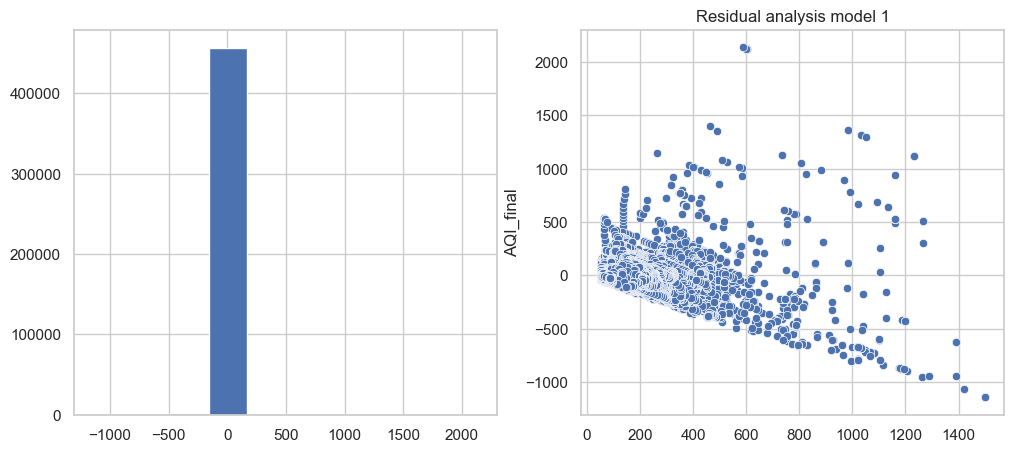

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(residuals)

sns.scatterplot(x=y_pred_val, y=residuals, ax=axes[1])
plt.title('Residual analysis model 1')

**Residual Analysis**
1. *Distribution of Residuals (Histogram):* The residual distribution is well-centered around zero. This indicates that the LightGBM model is unbiased on average. In general the destribution slightly right-skewed, meanig that model slightly overestimates the values, but in general model is quite precise.

2. *Residuals vs. Predicted Values (Scatter Plot):* The scatter plot reveals that the residuals are not perfectly random (homoscedastic). Instead, we observe distinct heteroscedasticity.

Low to Medium AQI: For lower predicted values, the residuals are tightly clustered around zero, indicating high precision.

High AQI: As the predicted AQI values increase, the variance of the residuals expands (a "funnel" shape).

**Conclusion:** While the model is robust for the majority of observations, the increasing error variance at high AQI levels suggests that extreme pollution events are inherently more volatile and harder to predict with high precision. However, the absence of clear non-linear patterns suggests the model has successfully captured the main relationships in the data.

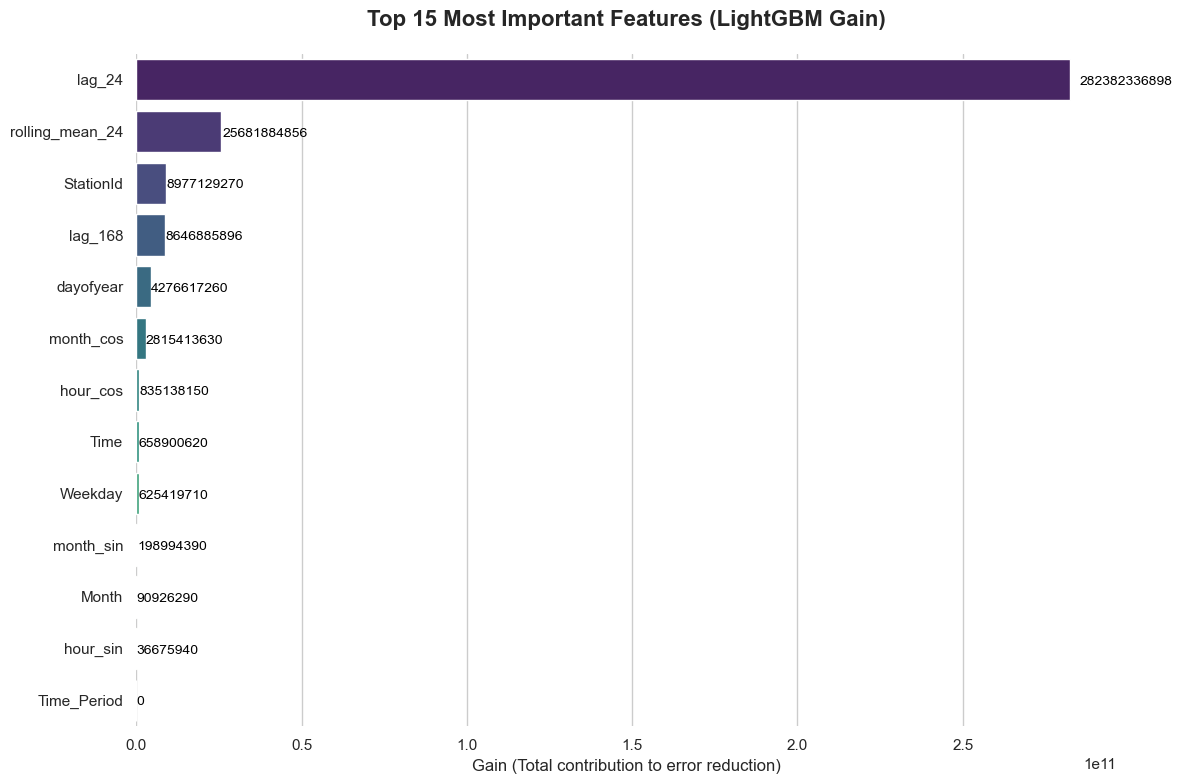

In [119]:
def plot_importance(model, X_train, num_features=15):
    
    importance_values = model.booster_.feature_importance(importance_type='gain')
    feature_names = X_train.columns
    
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Gain': importance_values
    })
    
    imp_df = imp_df.sort_values(by='Gain', ascending=False).head(num_features)
    
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid") # Чистый фон с сеткой
    
    ax = sns.barplot(x='Gain', y='Feature', data=imp_df, palette='viridis')
    
    plt.title(f'Top {num_features} Most Important Features (LightGBM Gain)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Gain (Total contribution to error reduction)', fontsize=12)
    plt.ylabel('') # Убираем подпись оси Y, названия признаков и так понятны
    
    sns.despine(left=True, bottom=True)
    
    for i, v in enumerate(imp_df['Gain']):
        ax.text(v + (v * 0.01), i + 0.1, f'{v:.0f}', color='black', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_importance(model, X_train, num_features=15)

**Features Importance Analysis**

The values on the graph (gain) represents to which extent this feature in the model reduces the error term for prediction.

The main feature in the predicting model is the AQI values lagged for 24 hours, this feature mainly reduces the error term for the predicting model. Also mean value for 24 hour and lagged values for 1 week (168 days) apper to be quite importat for the prediction. Less contribute time vriables such month, day, time, year.

We use **Recursive Forecasting Strategy** (Dynamic Simulation)

Since the standard batch prediction (e.g., `model.predict(X_test)`) is impossible for long-term forecasting because our model relies on **Lag Features**. For a date in December 2020, the "value from 24 hours ago" is unknown - it hasn't happened yet.

Therefore we implement an **Iterative Feedback Loop**:
1.  **Step:** Generate features for the current specific hour ($t$).
2.  **Predict:** Use the model to estimate AQI for $t$.
3.  **Update:** Write this prediction back into the dataset. It effectively becomes the "history" used to generate lags for future steps ($t+1, t+2...$).

In [120]:
# Define the date range for the forecast (July - Dec 2020)
future_dates = pd.date_range(start='2020-07-01 00:00:00', end='2020-12-31 23:00:00', freq='h')

In [121]:
# Create a Cartesian product of "All Stations" x "All Future Dates"
# We need a row for every station for every hour
stations = df['StationId'].unique()  # Get stations from the original dataset
future_df = pd.DataFrame([
    {'StationId': s, 'Datetime': d} 
    for s in stations 
    for d in future_dates
])

In [122]:
# Set correct data types
future_df['StationId'] = future_df['StationId'].astype('category')
future_df['AQI'] = np.nan  # Initialize target column with NaNs (to be filled by model)

In [123]:
future_df.describe()

,Datetime,AQI
count,485760,0.0
mean,2020-09-30 23:29:59.999999744,NaN
min,2020-07-01 00:00:00,NaN
25%,2020-08-15 23:45:00,NaN
50%,2020-09-30 23:30:00,NaN
75%,2020-11-15 23:15:00,NaN
max,2020-12-31 23:00:00,NaN
std,NaN,NaN


In [124]:
# Append "History Tail" (Last week of June)
# We need this data to calculate lags (e.g., lag_24) for the first few days of July.
# We take the last 168 hours (1 week) from the validation/original set.
history_tail = df[df['Datetime'] >= '2020-06-23'].copy()

# Keep only necessary columns to match the future structure
required_cols = ['StationId', 'Datetime', 'AQI_final']
history_tail = history_tail[required_cols]

In [125]:
# Merge History and Future into one simulation dataframe
# We will read from the past rows and write to the future rows in the loop.
full_simulation = pd.concat([history_tail, future_df], ignore_index=True)
full_simulation = full_simulation.sort_values(['StationId', 'Datetime']).reset_index(drop=True)

In [126]:
full_simulation.head()

,StationId,Datetime,AQI_final,AQI
0,AP001,2020-06-23 00:00:00,55.0,NaN
1,AP001,2020-06-23 01:00:00,55.0,NaN
2,AP001,2020-06-23 02:00:00,55.0,NaN
3,AP001,2020-06-23 03:00:00,55.0,NaN
4,AP001,2020-06-23 04:00:00,55.0,NaN


In [127]:
feature_cols = X_train.columns.tolist()

print(f"Starting simulation using {len(feature_cols)} features...")
full_simulation = full_simulation.drop_duplicates(subset=['StationId', 'Datetime'])

Starting simulation using 13 features...


In [128]:
station_dtype = full_simulation['StationId'].dtype
period_categories = ['Night', 'Morning', 'Day', 'Evening']
period_dtype = pd.CategoricalDtype(categories=period_categories, ordered=True)

for current_time in tqdm(future_dates):
    
    current_mask = (full_simulation['Datetime'] == current_time)
    
    if not current_mask.any():
        continue

    pred_batch = full_simulation.loc[current_mask, ['StationId']].copy()
    
    pred_batch['Month'] = current_time.month
    pred_batch['Weekday'] = current_time.weekday()
    pred_batch['Time'] = current_time.hour
    pred_batch['Year'] = current_time.year
    pred_batch['dayofyear'] = current_time.dayofyear

    # Time Period
    h = current_time.hour
    if 6 <= h < 12:
        period = 'Morning'
    elif 12 <= h < 18:
        period = 'Day'
    elif 18 <= h < 24:
        period = 'Evening'
    else:
        period = 'Night'
    
    pred_batch['Time_Period'] = period
    pred_batch['Time_Period'] = pred_batch['Time_Period'].astype(period_dtype)

    pred_batch['StationId'] = pred_batch['StationId'].astype(station_dtype)

    # Sin/Cos
    pred_batch['hour_sin'] = np.sin(2 * np.pi * h / 24)
    pred_batch['hour_cos'] = np.cos(2 * np.pi * h / 24)
    pred_batch['month_sin'] = np.sin(2 * np.pi * current_time.month / 12)
    pred_batch['month_cos'] = np.cos(2 * np.pi * current_time.month / 12)

    # Lag 24
    time_24_ago = current_time - pd.Timedelta(hours=24)
    aqi_24 = full_simulation.loc[full_simulation['Datetime'] == time_24_ago, ['StationId', 'AQI']]
    
    pred_batch = pred_batch.merge(aqi_24, on='StationId', how='left', suffixes=('', '_prev'))
    pred_batch = pred_batch.rename(columns={'AQI': 'lag_24'})
    
    # Lag 168
    time_168_ago = current_time - pd.Timedelta(hours=168)
    aqi_168 = full_simulation.loc[full_simulation['Datetime'] == time_168_ago, ['StationId', 'AQI']]
    
    pred_batch = pred_batch.merge(aqi_168, on='StationId', how='left')
    pred_batch = pred_batch.rename(columns={'AQI': 'lag_168'})

    pred_batch['lag_24'] = pred_batch['lag_24'].ffill().fillna(0)
    pred_batch['lag_168'] = pred_batch['lag_168'].ffill().fillna(0)

    pred_batch['rolling_mean_24'] = pred_batch['lag_24']
    
    X_test_step = pred_batch[feature_cols]
    
    # Теперь ошибки быть не должно, так как категории совпадают
    current_preds = model.predict(X_test_step)
    
    full_simulation.loc[current_mask, 'AQI'] = current_preds

100%|██████████████████████████████████████████████████████████████████████████████| 4416/4416 [02:54<00:00, 25.32it/s]


In [129]:
full_simulation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506496 entries, 0 to 506603
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   StationId  506496 non-null  category      
 1   Datetime   506496 non-null  datetime64[ns]
 2   AQI_final  20844 non-null   float64       
 3   AQI        485760 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(2)
memory usage: 15.9 MB


In [130]:
full_simulation

,StationId,Datetime,AQI_final,AQI
0,AP001,2020-06-23 00:00:00,55.0,NaN
1,AP001,2020-06-23 01:00:00,55.0,NaN
2,AP001,2020-06-23 02:00:00,55.0,NaN
3,AP001,2020-06-23 03:00:00,55.0,NaN
4,AP001,2020-06-23 04:00:00,55.0,NaN
...,...,...,...,...
506599,WB013,2020-12-31 19:00:00,NaN,210.27781
506600,WB013,2020-12-31 20:00:00,NaN,210.27781
506601,WB013,2020-12-31 21:00:00,NaN,210.27781
506602,WB013,2020-12-31 22:00:00,NaN,210.27781


In [131]:
history_data = df[df['Datetime'] < '2020-07-01'].copy()

forecast_data_lgbm = full_simulation.loc[
    full_simulation['Datetime'] >= '2020-07-01', 
    ['Datetime', 'AQI']
].copy()

hist_monthly = history_data.set_index('Datetime')['AQI_final'].resample('MS').mean()
fc_monthly = forecast_data_lgbm.set_index('Datetime')['AQI'].resample('MS').mean()

last_hist_point = hist_monthly.iloc[[-1]]

fc_monthly_connected = pd.concat([last_hist_point, fc_monthly])

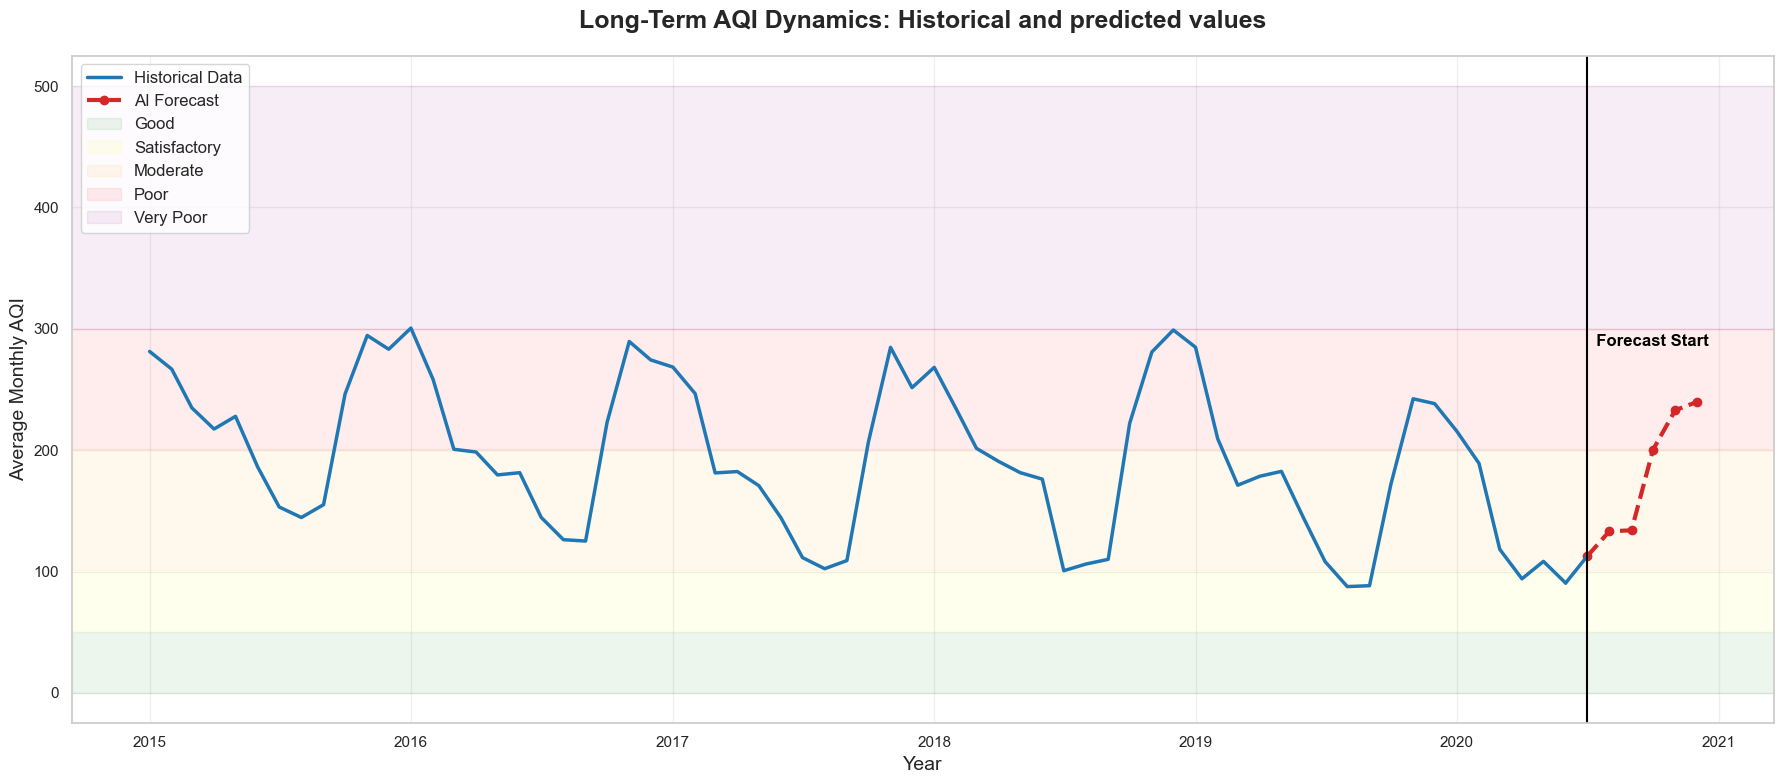

In [132]:
plt.figure(figsize=(18, 8))
sns.set_style("whitegrid")

# Historical data (blue line)
plt.plot(hist_monthly.index, hist_monthly.values, 
         label='Historical Data', color='#1f77b4', linewidth=2.5)

# Forecasted values (red line)
plt.plot(fc_monthly.index, fc_monthly.values, 
         label='AI Forecast', color='#d62728', linewidth=3, linestyle='--', marker='o')

# Connecting historical and predicted data
plt.plot([hist_monthly.index[-1], fc_monthly.index[0]], 
         [hist_monthly.values[-1], fc_monthly.values[0]], 
         color='#1f77b4', linestyle='-', linewidth=2.5)

# Verticel line (start of the forecast)
plt.axvline(pd.to_datetime('2020-07-01'), color='black', linestyle='-', linewidth=1.5)
plt.text(pd.to_datetime('2020-07-01'), plt.ylim()[1]*0.95, '  Forecast Start', 
         color='black', fontweight='bold', ha='left', va='top')

# Coluoring zones based on Air Quality 
full_index = pd.concat([hist_monthly, fc_monthly]).index
plt.axhspan(0, 50, color='green', alpha=0.07, label='Good')
plt.axhspan(51, 100, color='yellow', alpha=0.07, label='Satisfactory')
plt.axhspan(101, 200, color='orange', alpha=0.07, label='Moderate')
plt.axhspan(201, 300, color='red', alpha=0.07, label='Poor')
plt.axhspan(300, 500, color='purple', alpha=0.07, label='Very Poor')

plt.title('Long-Term AQI Dynamics: Historical and predicted values', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Average Monthly AQI', fontsize=14)
plt.xlabel('Year', fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left', frameon=True, fontsize=12)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Conclusion: LightGBM Forecasting Model**
- **Feature Engineering & Data Leakage Prevention:** We developed a LightGBM regressor using strictly temporal features (hour, month, seasonality via cyclical sin/cos transformations) and historical lags. We intentionally excluded concurrent pollutant measurements (e.g., current PM2.5, CO) to prevent data leakage, ensuring the model simulates a realistic forecasting scenario where future chemical compositions are unknown.
- **Recursive Forecasting Strategy:**
To predict AQI for the extended horizon (July–December 2020), we implemented a Recursive Multi-Step Strategy. This approach is essential for capturing the high inertia of air quality data: the model predicts one hour ahead ($t+1$), and this prediction is fed back into the dataset as a lag feature to generate the subsequent prediction ($t+2$), preserving the continuity of the time series
- **Adaptability to COVID-19 Anomalies:** Despite being trained on "normal" pre-pandemic conditions (2015–2019), the model showed remarkable robustness during the COVID-19 lockdown validation period (Jan–June 2020). This adaptability is driven by strong autocorrelation captured by lag features (specifically lag_24). These features act as a self-correcting mechanism, allowing the model to quickly adjust to the structural shift of lower pollution levels based on the immediate history, without requiring specific "lockdown" flags..

For defining clusters accurately, we firstly will work with stations to define the profile of the city in more details. Since stations might be located in differet parts of the city and differently describe the environment there. After clustering the stations we will overlap the results on the city level. 

Before clustering we firstly need to aggregate our data to the station level (before we were wroking with hourly data for each station). For this purpouse we need to apply feature engineering. And create variables that will capture the day, week, month and year dynamics for each pollutant tracked by the station. 

The following metrics will be calculated for the each pollutant from the dataset:
1. **Intensity (`{Pol}_Median`):** Represents the typical background pollution level at the station. Unlike the mean, it is robust against outliers and extreme measurement errors.
2. **Peaks (`{Pol}_P95`):** Represents hazardous pollution episodes. It indicates the pollution level that is exceeded only 5% of the time (worst-case scenarios).
3. **Cleanest State (`{Pol}_P05`):** Represents the baseline pollution level when local sources are inactive or ventilation is high. It filters out sensor noise (zeros) but captures the "cleanest" air available at that station.
4. **Pollution Amplitude (`{Pol}_Range_P95_P05`):** The absolute difference between the peak events and the cleanest state.
5. **Volatility (`{Pol}_CV`):** The Coefficient of Variation. It measures how unstable the pollution source is. A high value indicates sporadic, burst-like emissions; a low value indicates a constant, steady source (like a continuously running factory).
6. **Daily Cycle (`{Pol}_DayNight_Ratio`):** Compares pollution levels during active hours versus sleeping hours. Helps distinguish between traffic/office activity (high day values) and domestic heating/accumulation (high night values).
7. **Weekly Cycle (`{Pol}_Weekend_Ratio`):** Captures the "Weekend Effect." Measures the reduction in pollution when human economic activity (traffic, offices, industry) slows down.
8. **Annual Cycle (`{Pol}_WinterSummer_Ratio`):** Captures seasonal dependency, primarily serving as a proxy for heating emissions (winter peaks) versus photochemical smog or dust (summer peaks).

Initially we have 11 pollutants and create 8 variables for each. Thus, as a result we have 88 variables.

In [133]:
# Data aggreagtion to the station level
def preprocess_air_quality_data(df):
    
    # Copy to avoid SettingWithCopy warnings
    data = df.copy()
    
    # Drop rows with missing essential metadata
    # We don't drop rows with missing pollutants yet, as they might exist for other pollutants
    data = data.dropna(subset=['StationId', 'Month', 'Weekday', 'Time_Period'])
    
    # Pre-calculate boolean masks for temporal cycles (Vectorized operations)
    # Daily Cycle: 'Night' vs everything else
    data['is_night'] = data['Time_Period'] == 'Night'
    
    # Weekly Cycle: Saturday (5) and Sunday (6)
    data['is_weekend'] = data['Weekday'].isin([5, 6])
    
    # Annual Cycle: Season mapping
    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        if month in [6, 7, 8]: return 'Summer'
        return 'Other'
        
    data['season_calc'] = data['Month'].apply(get_season)
    
    print(f"Preprocessing complete. Rows: {len(data)}")
    return data

In [134]:
df_clean = preprocess_air_quality_data(station_hour)

Preprocessing complete. Rows: 2589083


In [135]:
df_clean.head()

,Datetime,StationId,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,Time_Period,StationName,City,State,Status,AQI_final,AQI_bucket_final,is_night,is_weekend,season_calc
0,2017-11-24 17:00:00,AP001,60.50,98.00,2.35,30.80,18.25,8.50,0.1,11.85,...,Day,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,NaN,NaN,False,False,Other
1,2017-11-24 18:00:00,AP001,65.50,111.25,2.70,24.20,15.07,9.77,0.1,13.17,...,Evening,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,NaN,NaN,False,False,Other
2,2017-11-24 19:00:00,AP001,80.00,132.00,2.10,25.18,15.15,12.02,0.1,12.08,...,Evening,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,NaN,NaN,False,False,Other
3,2017-11-24 20:00:00,AP001,81.50,133.25,1.95,16.25,10.23,11.58,0.1,10.47,...,Evening,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,NaN,NaN,False,False,Other
4,2017-11-24 21:00:00,AP001,75.25,116.00,1.43,17.48,10.43,12.03,0.1,9.12,...,Evening,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,NaN,NaN,False,False,Other


In [136]:
def calculate_statistical_features(df, pollutants):
    """
    Calculates basic stats (Median, P05, P95, CV, Range)
    """    
    stations = df['StationId'].unique()
    stats_df = pd.DataFrame(index=stations)
    
    # Aggregation: Calculate all base stats in one efficient 'groupby' pass
    agg_funcs = {
        'Median': 'median',
        'P05': lambda x: x.quantile(0.05),
        'P95': lambda x: x.quantile(0.95),
        'Mean': 'mean',
        'Std': 'std'
    }
    
    # Group by StationId and calculate stats for ALL pollutants at once
    # Result is a MultiIndex columns dataframe
    grouped = df.groupby('StationId')[pollutants].agg(list(agg_funcs.values()))
    
    # Rename columns to match our aggregation names (optional, for clarity inside loop)
    # But it's easier to access via MultiIndex: grouped[('NO2', 'median')]
    
    for pol in pollutants:
        # Accessing the calculated stats using the function names/aliases
        # We assume the order matches agg_funcs.values()
        
        # 1. Intensity (Median)
        stats_df[f'{pol}_Median'] = grouped[pol].iloc[:, 0] # First agg func is median
        
        # 2. Cleanest State (P05)
        p05 = grouped[pol].iloc[:, 1]
        stats_df[f'{pol}_P05'] = p05
        
        # 3. Peaks (P95)
        p95 = grouped[pol].iloc[:, 2]
        stats_df[f'{pol}_P95'] = p95
        
        # 4. Range (Amplitude)
        stats_df[f'{pol}_Range_P95_P05'] = p95 - p05
        
        # 5. Volatility (CV)
        mean_val = grouped[pol].iloc[:, 3]
        std_val = grouped[pol].iloc[:, 4]
        stats_df[f'{pol}_CV'] = std_val / (mean_val + 1e-6)
        
    return stats_df

In [137]:
# Define your target pollutants
target_pollutants = ['PM2.5', 'PM10','NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene']
features_stats = calculate_statistical_features(df_clean, target_pollutants)
print("Stats shape:", features_stats.shape)

Stats shape: (110, 55)


In [138]:
def calculate_temporal_features(df, pollutants):
    """
    Calculates cycle ratios (Day/Night, Weekend/Workday, Winter/Summer)
    """
    stations = df['StationId'].unique()
    temp_df = pd.DataFrame(index=stations)
    
    # Dayly cycle
    daily_pivot = df.pivot_table(
        index='StationId', columns='is_night', values=pollutants, aggfunc='mean'
    )
    
    # Weekly cycle
    weekly_pivot = df.pivot_table(
        index='StationId', columns='is_weekend', values=pollutants, aggfunc='mean'
    )
    
    # Seasonal cycle
    season_mask = df['season_calc'].isin(['Winter', 'Summer'])
    seasonal_pivot = df[season_mask].pivot_table(
        index='StationId', columns='season_calc', values=pollutants, aggfunc='mean'
    )
    
    # Calculating ratios
    for pol in pollutants:
        # 1. Day/Night Ratio (False=Day, True=Night)
        if (pol, False) in daily_pivot.columns and (pol, True) in daily_pivot.columns:
            temp_df[f'{pol}_DayNight_Ratio'] = daily_pivot[(pol, False)] / (daily_pivot[(pol, True)] + 1e-6)
            
        # 2. Weekend Ratio (False=Workday, True=Weekend)
        if (pol, True) in weekly_pivot.columns and (pol, False) in weekly_pivot.columns:
            temp_df[f'{pol}_Weekend_Ratio'] = weekly_pivot[(pol, True)] / (weekly_pivot[(pol, False)] + 1e-6)
            
        # 3. Winter/Summer Ratio
        if (pol, 'Winter') in seasonal_pivot.columns and (pol, 'Summer') in seasonal_pivot.columns:
            temp_df[f'{pol}_WinterSummer_Ratio'] = seasonal_pivot[(pol, 'Winter')] / (seasonal_pivot[(pol, 'Summer')] + 1e-6)
            
    return temp_df

In [139]:
features_temporal = calculate_temporal_features(df_clean, target_pollutants)
print("Temporal features shape:", features_temporal.shape)

Temporal features shape: (110, 33)


In [140]:
def finalize_dataset(stats_df, temporal_df):
    """
    Step 4: Merges features and handles missing values.
    """
    # Merge on index (StationId)
    final_df = pd.concat([stats_df, temporal_df], axis=1)
    
    # Replace infinite values with NaN
    final_df = final_df.replace([np.inf, -np.inf], np.nan)
    
    # Fill NaN with Median (Robust imputation)
    # We use column-wise median
    final_df = final_df.fillna(final_df.median())
    
    # Sort columns alphabetically for better readability
    final_df = final_df.sort_index(axis=1)
    
    print(f"Final Dataset Ready. Shape: {final_df.shape}")
    return final_df

In [141]:
station_profile_final = finalize_dataset(features_stats, features_temporal)
station_profile_final.head()

Final Dataset Ready. Shape: (110, 88)


,Benzene_CV,Benzene_DayNight_Ratio,Benzene_Median,Benzene_P05,Benzene_P95,Benzene_Range_P95_P05,Benzene_Weekend_Ratio,Benzene_WinterSummer_Ratio,CO_CV,CO_DayNight_Ratio,...,SO2_Weekend_Ratio,SO2_WinterSummer_Ratio,Toluene_CV,Toluene_DayNight_Ratio,Toluene_Median,Toluene_P05,Toluene_P95,Toluene_Range_P95_P05,Toluene_Weekend_Ratio,Toluene_WinterSummer_Ratio
AP001,10.192371,1.337336,0.10,0.0,1.0000,1.0000,1.277378,0.333014,0.834377,1.018638,...,0.934027,1.300971,5.818948,0.841472,0.632667,0.00,6.620000,6.620000,0.720513,0.697054
AP005,0.843365,1.039525,3.35,0.0,10.2580,10.2580,0.960245,1.245364,0.952370,1.203462,...,1.016796,0.826531,0.935419,0.936660,6.900000,0.00,22.200000,22.200000,0.986045,0.931992
AS001,5.479457,1.387082,0.23,0.0,6.5495,6.5495,0.583218,0.315622,0.852865,0.694436,...,1.021056,1.080350,0.000000,1.000000,2.960000,2.96,2.960000,0.000000,1.000000,1.000000
BR005,1.305964,1.070895,1.54,0.0,10.6560,10.6560,1.073303,4.691126,0.962802,1.104748,...,0.999416,4.070716,1.302783,1.112997,3.370000,0.00,9.803333,9.803333,0.964419,0.863160
BR006,1.227756,0.913135,1.31,0.0,7.6560,7.6560,1.068731,2.440758,0.445820,0.957317,...,0.963045,1.361561,3.730559,1.134933,0.220000,0.00,1.130000,1.130000,0.944038,1.855972


**Currently we have created dataset aggregated to station level and containing 88 features. This hight number of variables might negatively affect the clustering result. Therefore, we need to reduce dataset dimensionality by applying PCA method.**

In [142]:
# PCA is sensetive to the scales, thus it is essential to scale the values before applying dimentionality reduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(station_profile_final)

In [143]:
station_profile_final.columns

Index(['Benzene_CV', 'Benzene_DayNight_Ratio', 'Benzene_Median', 'Benzene_P05',
       'Benzene_P95', 'Benzene_Range_P95_P05', 'Benzene_Weekend_Ratio',
       'Benzene_WinterSummer_Ratio', 'CO_CV', 'CO_DayNight_Ratio', 'CO_Median',
       'CO_P05', 'CO_P95', 'CO_Range_P95_P05', 'CO_Weekend_Ratio',
       'CO_WinterSummer_Ratio', 'NH3_CV', 'NH3_DayNight_Ratio', 'NH3_Median',
       'NH3_P05', 'NH3_P95', 'NH3_Range_P95_P05', 'NH3_Weekend_Ratio',
       'NH3_WinterSummer_Ratio', 'NO2_CV', 'NO2_DayNight_Ratio', 'NO2_Median',
       'NO2_P05', 'NO2_P95', 'NO2_Range_P95_P05', 'NO2_Weekend_Ratio',
       'NO2_WinterSummer_Ratio', 'NO_CV', 'NO_DayNight_Ratio', 'NO_Median',
       'NO_P05', 'NO_P95', 'NO_Range_P95_P05', 'NO_Weekend_Ratio',
       'NO_WinterSummer_Ratio', 'NOx_CV', 'NOx_DayNight_Ratio', 'NOx_Median',
       'NOx_P05', 'NOx_P95', 'NOx_Range_P95_P05', 'NOx_Weekend_Ratio',
       'NOx_WinterSummer_Ratio', 'O3_CV', 'O3_DayNight_Ratio', 'O3_Median',
       'O3_P05', 'O3_P95', 'O3_Ran

In [144]:
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)

In [145]:
n_components = pca.n_components_
explained_variance = np.sum(pca.explained_variance_ratio_)
    
print(f"Исходных признаков: {station_profile_final.shape[1]}")
print(f"Осталось компонент: {n_components}")
print(f"Сохранено информации (дисперсии): {explained_variance:.2%}")

Исходных признаков: 88
Осталось компонент: 28
Сохранено информации (дисперсии): 90.70%


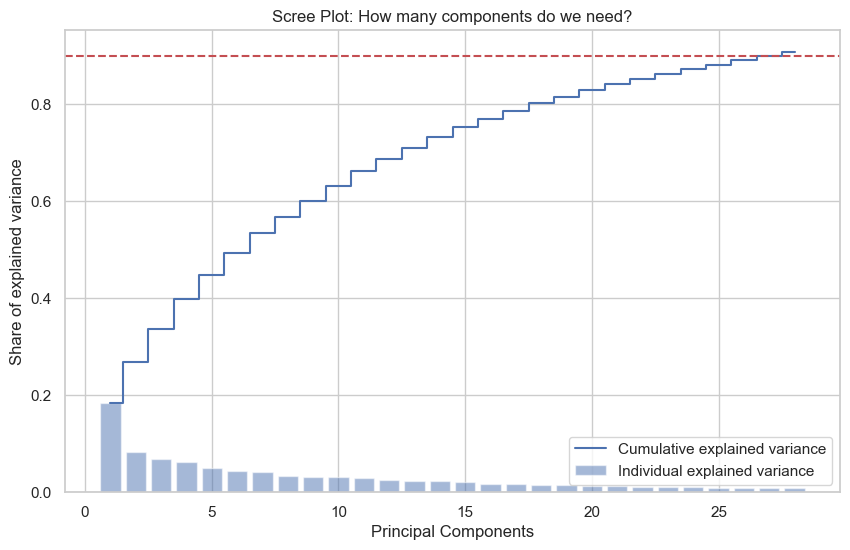

In [146]:
exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)
    
plt.figure(figsize=(10, 6))
    
plt.bar(range(1, len(exp_var)+1), exp_var, alpha=0.5, align='center',
            label='Individual explained variance')
    
plt.step(range(1, len(cum_var)+1), cum_var, where='mid',
             label='Cumulative explained variance')
    
plt.ylabel('Share of explained variance')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
plt.title("Scree Plot: How many components do we need?")
plt.show()

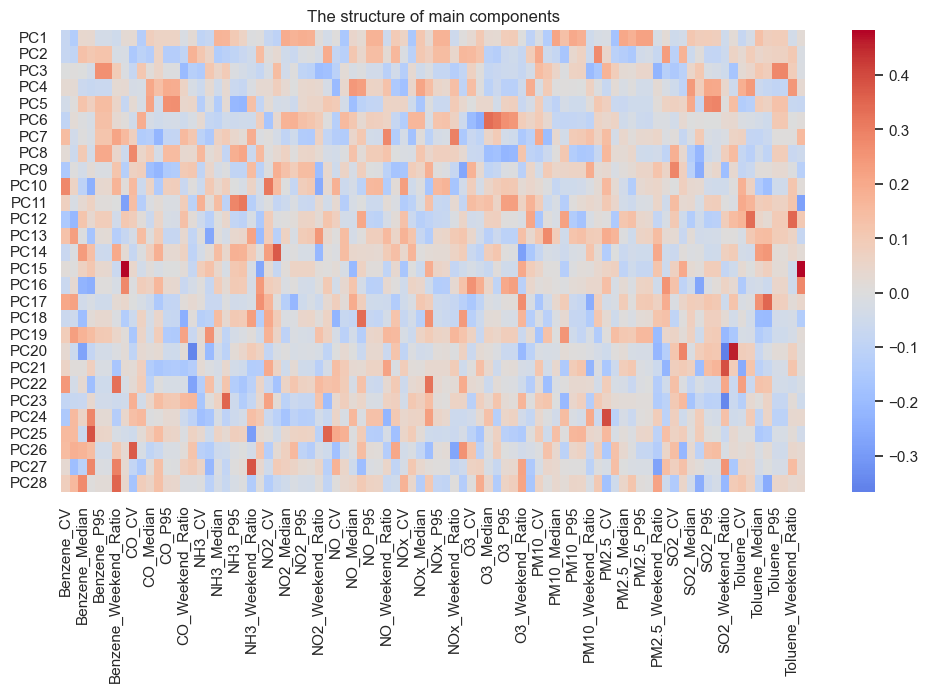

In [147]:
components_df = pd.DataFrame(
        pca.components_, 
        columns=station_profile_final.columns,
        index=[f'PC{i+1}' for i in range(pca.n_components_)]
    )
    
plt.figure(figsize=(12, 6))
sns.heatmap(components_df.head(28), cmap='coolwarm', center=0)
plt.title("The structure of main components")
plt.show()

In [148]:
print("\n--- Components structure ---")
for i in range(min(28, pca.n_components_)):
        pc_name = f'PC{i+1}'
        print(f"\n{pc_name} mainly depends on:")
        top_features = components_df.loc[pc_name].abs().sort_values(ascending=False).head(5)
        print(top_features)


--- Components structure ---

PC1 mainly depends on:
PM2.5_P95              0.220626
PM2.5_Range_P95_P05    0.218972
PM10_Median            0.211758
PM2.5_Median           0.205555
PM10_P95               0.199232
Name: PC1, dtype: float64

PC2 mainly depends on:
PM10_WinterSummer_Ratio     0.271913
PM2.5_WinterSummer_Ratio    0.231776
PM10_CV                     0.202661
NO2_WinterSummer_Ratio      0.191608
CO_WinterSummer_Ratio       0.174561
Name: PC2, dtype: float64

PC3 mainly depends on:
Toluene_Range_P95_P05    0.281283
Toluene_P95              0.280697
Benzene_Range_P95_P05    0.262113
Benzene_P95              0.261792
PM2.5_Weekend_Ratio      0.224072
Name: PC3, dtype: float64

PC4 mainly depends on:
Toluene_Weekend_Ratio     0.246363
NO_Median                 0.242056
SO2_Median                0.240852
Toluene_DayNight_Ratio    0.240004
NO_P05                    0.226003
Name: PC4, dtype: float64

PC5 mainly depends on:
SO2_Range_P95_P05    0.290697
SO2_P95              0.280

In [149]:
station_profile_final

,Benzene_CV,Benzene_DayNight_Ratio,Benzene_Median,Benzene_P05,Benzene_P95,Benzene_Range_P95_P05,Benzene_Weekend_Ratio,Benzene_WinterSummer_Ratio,CO_CV,CO_DayNight_Ratio,...,SO2_Weekend_Ratio,SO2_WinterSummer_Ratio,Toluene_CV,Toluene_DayNight_Ratio,Toluene_Median,Toluene_P05,Toluene_P95,Toluene_Range_P95_P05,Toluene_Weekend_Ratio,Toluene_WinterSummer_Ratio
AP001,10.192371,1.337336,0.10,0.000,1.0000,1.0000,1.277378,0.333014,0.834377,1.018638,...,0.934027,1.300971,5.818948,0.841472,0.632667,0.000000,6.620000,6.620000,0.720513,0.697054
AP005,0.843365,1.039525,3.35,0.000,10.2580,10.2580,0.960245,1.245364,0.952370,1.203462,...,1.016796,0.826531,0.935419,0.936660,6.900000,0.000000,22.200000,22.200000,0.986045,0.931992
AS001,5.479457,1.387082,0.23,0.000,6.5495,6.5495,0.583218,0.315622,0.852865,0.694436,...,1.021056,1.080350,0.000000,1.000000,2.960000,2.960000,2.960000,0.000000,1.000000,1.000000
BR005,1.305964,1.070895,1.54,0.000,10.6560,10.6560,1.073303,4.691126,0.962802,1.104748,...,0.999416,4.070716,1.302783,1.112997,3.370000,0.000000,9.803333,9.803333,0.964419,0.863160
BR006,1.227756,0.913135,1.31,0.000,7.6560,7.6560,1.068731,2.440758,0.445820,0.957317,...,0.963045,1.361561,3.730559,1.134933,0.220000,0.000000,1.130000,1.130000,0.944038,1.855972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WB009,1.736667,0.652256,4.55,0.720,41.1700,40.4500,0.888980,1.567782,0.867852,0.765521,...,0.994001,2.642833,1.368204,0.724354,12.450000,0.180000,54.902500,54.722500,1.059124,3.263763
WB010,0.818439,0.796150,52.88,1.115,148.0100,146.8950,1.075745,1.760191,0.916642,0.741298,...,0.995071,2.113585,0.983503,0.769692,53.482857,4.320553,197.425000,193.104447,1.010347,1.915700
WB011,1.482201,0.695762,3.85,0.340,24.2560,23.9160,0.918727,2.409862,1.119980,0.817232,...,0.929468,1.809159,1.375970,0.814854,7.340000,0.663158,41.729000,41.065842,0.894780,1.238683
WB012,1.558309,0.715902,4.00,0.770,33.7275,32.9575,0.876581,5.213138,1.247608,0.907857,...,1.000646,3.966425,1.280625,0.681590,6.385000,1.200000,39.210000,38.010000,0.973267,3.814536


In [150]:
X_pca.shape

(110, 28)

To define number of clusters mathematically and find out for what number of clusters the distance between data points within one cluster is smaller (Elbow method) and how well datapoints fit defined clusters (Silhouette method).

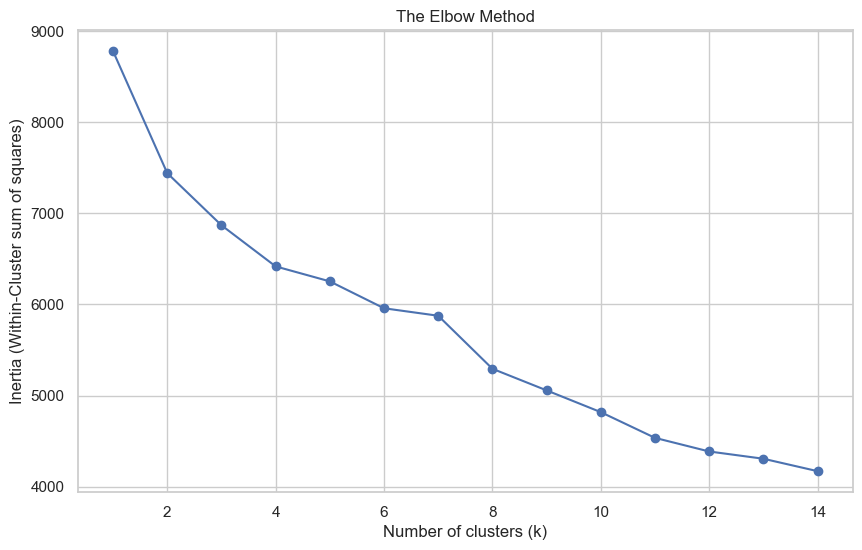

In [151]:
inertia = []
K_range = range(1, 15)  # Test k from 1 to 15

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)  # Use your PCA data (28 components)
    inertia.append(kmeans.inertia_)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster sum of squares)')
plt.show()

The Elbow method shows that in general, the main metric whithin cluster sum of squares is gradually decreasing with growing number of clusters. The smaller the within-cluster sum of squares the tighter is the cluster.

The greatest decrease in the metrics is for the 8 clusters. However, we also need to take into accpunt the Shilouette method.

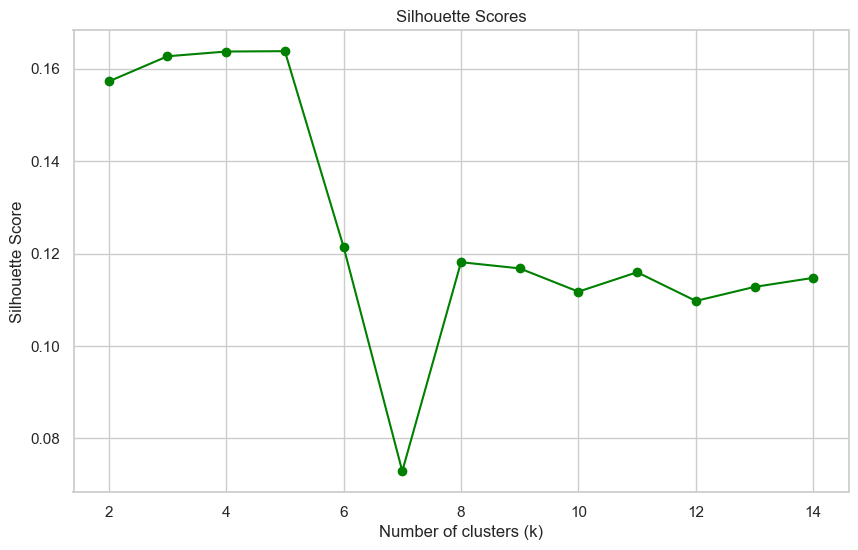

In [152]:
silhouette_scores = []
K_range_sil = range(2, 15) # Silhouette cannot be calculated for k=1

for k in K_range_sil:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    
    # Calculate average score for this k
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(K_range_sil, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

For Silhouette method, where the Silhouette score shows how well datapoints suit the defined number of clusters. The higher the silhouette score (the closer to 1) the better, meaning that the datapoints are closer to the datapoints from its own cluster and far away from the datapoints of the neighbouring cluster. The values close to 0 mean that the datapoints are closer to the neighbourig cluster rather than to the datapoints of its own cluster.

In our case there is the local minimum of the silhouette score fir 7 clusters, meanwhile maximum score is achieved for the 5 clusters. Considering this it will be better to choose 5 clusters.

In [153]:
kmeans = KMeans(n_clusters=5, random_state=42)

labels = kmeans.fit_predict(X_pca) 

df_analysis = station_profile_final.copy()
df_analysis['Cluster'] = labels

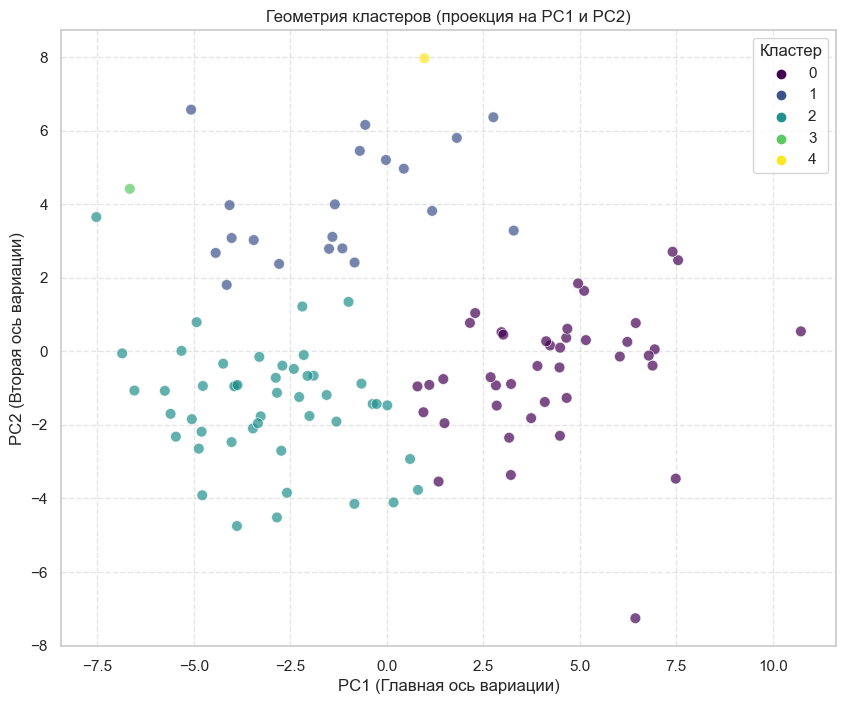

In [154]:
def plot_pca_clusters(X_pca, labels):
    plt.figure(figsize=(10, 8))
    
    pca_viz = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
    pca_viz['Cluster'] = labels
    
    # Рисуем
    sns.scatterplot(
        data=pca_viz, 
        x='PC1', 
        y='PC2', 
        hue='Cluster', 
        palette='viridis', 
        s=60,
        alpha=0.7
    )
    
    plt.title('Геометрия кластеров (проекция на PC1 и PC2)')
    plt.xlabel('PC1 (Главная ось вариации)')
    plt.ylabel('PC2 (Вторая ось вариации)')
    plt.legend(title='Кластер')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# ЗАПУСК
plot_pca_clusters(X_pca, labels)

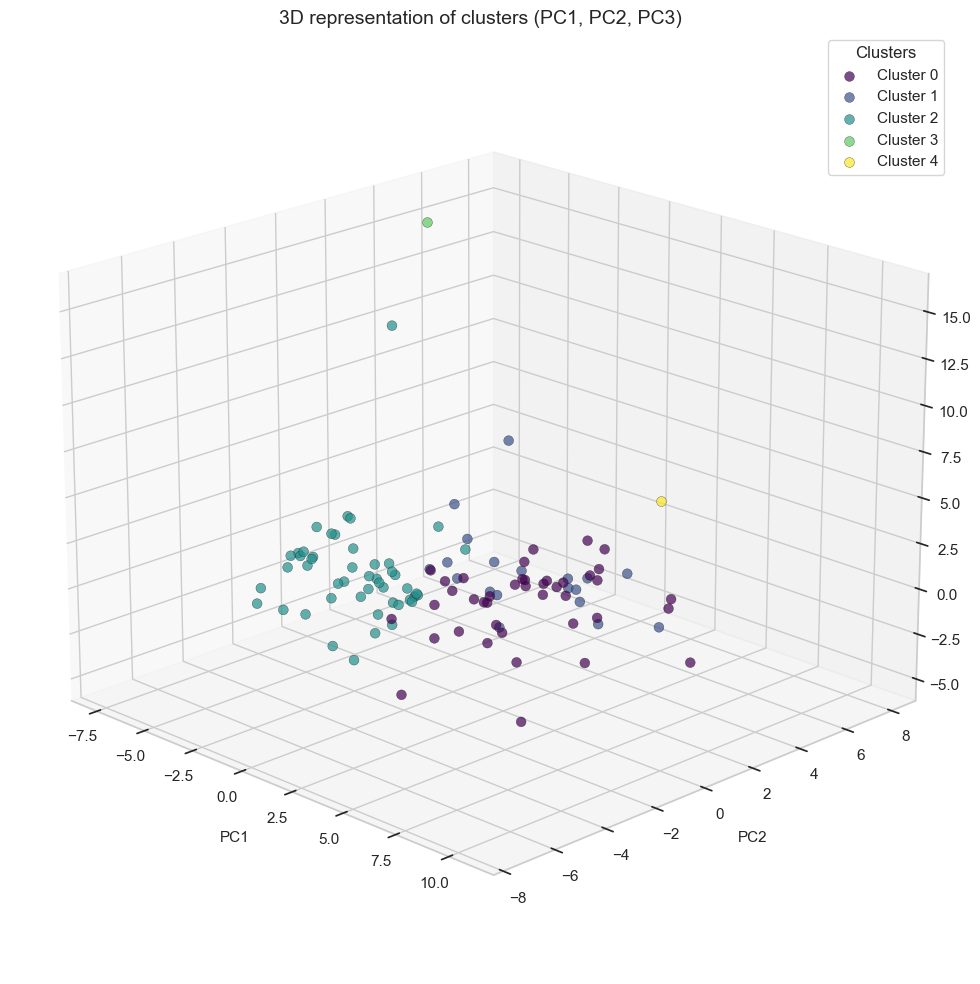

In [155]:
def plot_pca_clusters_3d(X_pca, labels):
    """
    Строит 3D scatter plot by first three PCA.
    """
    if X_pca.shape[1] < 3:
        print("Error: For this 3D graph minimum 3 PC needed in X_pca.")
        return

    pca_viz = pd.DataFrame(X_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])
    pca_viz['Cluster'] = labels

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
    
    for i, cluster_label in enumerate(unique_labels):
        cluster_data = pca_viz[pca_viz['Cluster'] == cluster_label]
        
        ax.scatter(
            xs=cluster_data['PC1'], 
            ys=cluster_data['PC2'], 
            zs=cluster_data['PC3'], 
            c=[colors[i]],           
            label=f'Cluster {cluster_label}',
            s=50,                    # dots size
            alpha=0.7,               # transparency
            edgecolor='k', linewidth=0.3 # thin outline for dots
        )

    ax.set_title('3D representation of clusters (PC1, PC2, PC3)', fontsize=14)
    ax.set_xlabel('PC1', fontsize=11, labelpad=10)
    ax.set_ylabel('PC2', fontsize=11, labelpad=10)
    ax.set_zlabel('PC3', fontsize=11, labelpad=10)

    ax.legend(title="Clusters", loc='best')
    
    ax.view_init(elev=20, azim=-45) 

    plt.tight_layout()
    plt.show()

plot_pca_clusters_3d(X_pca, labels)

In [156]:
# statistics for each cluster
clusters_stats = pd.DataFrame(df_analysis.groupby('Cluster').median()).reset_index()
clusters_stats

,Cluster,Benzene_CV,Benzene_DayNight_Ratio,Benzene_Median,Benzene_P05,Benzene_P95,Benzene_Range_P95_P05,Benzene_Weekend_Ratio,Benzene_WinterSummer_Ratio,CO_CV,...,SO2_Weekend_Ratio,SO2_WinterSummer_Ratio,Toluene_CV,Toluene_DayNight_Ratio,Toluene_Median,Toluene_P05,Toluene_P95,Toluene_Range_P95_P05,Toluene_Weekend_Ratio,Toluene_WinterSummer_Ratio
0,0,1.155606,0.767111,1.940,0.130,10.0300,10.030000,0.951698,2.683264,0.909633,...,0.977368,1.368879,1.278427,0.754503,13.280000,0.500000,70.000000,68.280000,0.945205,1.838383
1,1,1.598193,0.862742,1.425,0.065,14.6095,14.384500,0.932370,3.704419,0.852792,...,0.988809,1.831645,1.994082,1.099956,0.515000,0.000000,3.382250,2.467250,0.969929,3.539149
2,2,2.129520,0.999999,0.430,0.000,4.5200,4.141291,0.962665,1.911581,0.834377,...,0.989164,1.303419,2.122090,1.051804,1.200000,0.000000,6.957000,6.620000,0.976066,1.809456
3,3,3.404726,1.004405,0.170,0.000,440.2155,440.215500,1.214835,14.245205,0.795678,...,0.973102,0.716024,3.392516,1.008537,0.150000,0.000000,440.082125,440.082125,1.211966,13.149106
4,4,0.818439,0.796150,52.880,1.115,148.0100,146.895000,1.075745,1.760191,0.916642,...,0.995071,2.113585,0.983503,0.769692,53.482857,4.320553,197.425000,193.104447,1.010347,1.915700


In [157]:
station_meta = station_hour[['StationId', 'StationName', 'City', 'State']]
station_grouped = station_meta.drop_duplicates(subset=['StationId']).reset_index(drop=True)

station_grouped.head()

,StationId,StationName,City,State
0,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh
1,AP005,"GVM Corporation, Visakhapatnam - APPCB",Visakhapatnam,Andhra Pradesh
2,AS001,"Railway Colony, Guwahati - APCB",Guwahati,Assam
3,BR005,"DRM Office Danapur, Patna - BSPCB",Patna,Bihar
4,BR006,"Govt. High School Shikarpur, Patna - BSPCB",Patna,Bihar


In [158]:
df_analysis = df_analysis.merge(station_grouped, 
                  left_index=True,
                 right_on = 'StationId')

In [159]:
city_cluster_counts = pd.crosstab(
    index=df_analysis['City'], 
    columns=df_analysis['Cluster'],
    margins=True,
    margins_name="Total"
)

city_cluster_counts = city_cluster_counts.sort_values('Total', ascending=False)

city_cluster_counts

Cluster,0,1,2,3,4,Total
City,,,,,,
Total,41,20,47,1,1,110
Delhi,38,0,0,0,0,38
Bengaluru,0,0,10,0,0,10
Mumbai,0,7,3,0,0,10
Kolkata,0,6,0,0,1,7
Patna,1,4,1,0,0,6
Hyderabad,0,0,6,0,0,6
Lucknow,0,0,5,0,0,5
Chennai,0,0,4,0,0,4


In [160]:
city_cluster_shares = pd.crosstab(
    index=df_analysis['City'], 
    columns=df_analysis['Cluster'],
    normalize='index'
)

city_cluster_percentages = (city_cluster_shares * 100).round(1)
city_cluster_percentages

city_cluster_percentages.merge(city_cluster_counts, on='City')

Cluster,0_x,1_x,2_x,3_x,4_x,0_y,1_y,2_y,3_y,4_y,Total
City,,,,,,,,,,,
Ahmedabad,100.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1
Aizawl,0.0,0.0,100.0,0.0,0.0,0,0,1,0,0,1
Amaravati,0.0,0.0,100.0,0.0,0.0,0,0,1,0,0,1
Amritsar,0.0,0.0,100.0,0.0,0.0,0,0,1,0,0,1
Bengaluru,0.0,0.0,100.0,0.0,0.0,0,0,10,0,0,10
Bhopal,0.0,0.0,100.0,0.0,0.0,0,0,1,0,0,1
Brajrajnagar,0.0,0.0,100.0,0.0,0.0,0,0,1,0,0,1
Chandigarh,0.0,0.0,100.0,0.0,0.0,0,0,1,0,0,1
Chennai,0.0,0.0,100.0,0.0,0.0,0,0,4,0,0,4


In [161]:
# distribution of clusters among the variables
city_cluster_total = city_cluster_counts.merge(city_cluster_percentages, on='City')
city_cluster_total = city_cluster_total.rename(columns = {
    '0_x':'0_cnt', 
    '1_x':'1_cnt', 
    '2_x':'2_cnt', 
    '3_x':'3_cnt',
    '4_x':'4_cnt', 
    'Total':'Total_cnt', 
    '0_y':'0_share', 
    '1_y':'1_share', 
    '2_y':'2_share',
    '3_y':'3_share', 
    '4_y':'4_share'
})
city_cluster_total = city_cluster_total[['0_cnt', '0_share', 
                                         '1_cnt', '1_share', 
                                         '2_cnt', '2_share', 
                                         '3_cnt', '3_share', 
                                         '4_cnt', '4_share',
                                         'Total_cnt']]
city_cluster_total

Cluster,0_cnt,0_share,1_cnt,1_share,2_cnt,2_share,3_cnt,3_share,4_cnt,4_share,Total_cnt
City,,,,,,,,,,,
Delhi,38,100.0,0,0.0,0,0.0,0,0.0,0,0.0,38
Bengaluru,0,0.0,0,0.0,10,100.0,0,0.0,0,0.0,10
Mumbai,0,0.0,7,70.0,3,30.0,0,0.0,0,0.0,10
Kolkata,0,0.0,6,85.7,0,0.0,0,0.0,1,14.3,7
Patna,1,16.7,4,66.7,1,16.7,0,0.0,0,0.0,6
Hyderabad,0,0.0,0,0.0,6,100.0,0,0.0,0,0.0,6
Lucknow,0,0.0,0,0.0,5,100.0,0,0.0,0,0.0,5
Chennai,0,0.0,0,0.0,4,100.0,0,0.0,0,0.0,4
Gurugram,1,25.0,0,0.0,3,75.0,0,0.0,0,0.0,4
